# New Trees Models

In this notebook I will test multiple different models using decision trees

## Mix of Linear Model and Decision Tree

Eventhough Decision trees are great, as they're interpretable models and doesn't requiere any assumptions about the input data. But the limitations of a Decision Tree is that is the results are constant approximations obtained at the end of the optimal data splitting process. This make the models to overfit easily if the growth is not monitored. 

There is a generalization over the classic decisison trees, these are called **Model Trees**. They learn an optimal splitting of the training data, as in the standard decision tree, with the main difference that the goodness of splits is evaluated fitting models. A particular case of the **Model Trees** is known as **Linear Tree**. This implies having Linear Models insted of simple constant approximations. 

To train this models we can use the *linear-tree* python library, which is develop to be full integrable with scikit-learn. They're wrappers that build a Decision Tree on the data fitting a linear estimator from *sklearn.linear_model*. All the models available in *sklearn.linear_model* can be used as linear estimators. 

The splits thresholds in each feature are derived through quantile binning to make the process faster. The only parameters involved are the *loss criterion*, *max_depth*, *min_samples_split*, *min_samples_leaf* and *max_bins*.

### Linear Tree for Classification

In [1]:
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from celluloid import Camera
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, Ridge

from lineartree import LinearForestClassifier

In [2]:
def gen_timeseries_dataset(n_samples,n_features,level=0,random_state=0):
    np.random.seed(random_state)
    X=np.sin(np.random.normal(0,1,(n_samples,n_features)))
    X=np.cumsum(X,axis=0)
    X+=level
    
    coef=np.exp(np.random.uniform(0,2,n_features))-1
    y=X.dot(coef)
    
    return X,y

In [3]:
### Utility variables:

thresholds=[0,-.1,-.2,-.3,-.4]
models=['RF','RF_STACK_OOB','LINEAR_RF']
f_scoring={m:{t:[]for t in thresholds}for m in models}
p_scoring={m:{t:[]for t in thresholds}for m in models}
r_scoring={m:{t:[]for t in thresholds}for m in models}

boxplotcolorprop=lambda c: {'medianprops':{'c':'line','linewidth':1.5},
                            'boxprops':{'c':c},
                            'whiskerprops':{'c':c},
                            'capprops':{'c',c}}

scores2str = lambda scores,name: \
                    name.ljust(11,' ')+' | ' + \
                    ' | '.join([f"({t}): {str(round(np.mean(s),3)).ljust(5,'0')}" for t,s in scores.items()])    

In [4]:
X,y=gen_timeseries_dataset(n_samples=20000,n_features=10,level=100,random_state=2)
X.shape,y.shape

((20000, 10), (20000,))

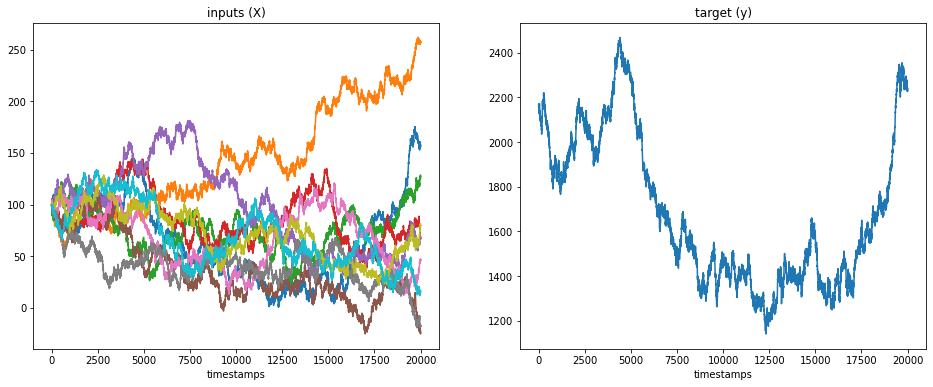

In [5]:
plt.figure(figsize=(16,6))
plt.subplot(121)
plt.plot(X)
plt.xlabel('timestamps');plt.title('inputs (X)')
plt.subplot(122)
plt.plot(y)
plt.xlabel('timestamps');plt.title('target (y)')
plt.show()

<ipython-input-8-5d809505c6ff>:16: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(121)
<ipython-input-8-5d809505c6ff>:22: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(122)
<ipython-input-8-5d809505c6ff>:16: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.

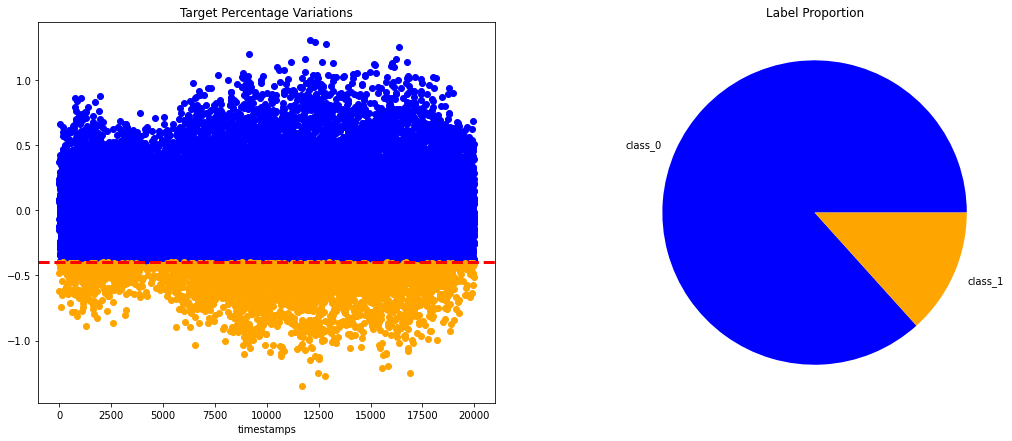

In [8]:
## Simulate Label Generation Process as Function of Threshold level

pct_change = np.diff(y)
pct_change = pct_change / y[:-1] *100
index = np.arange(len(pct_change))

fig = plt.figure(figsize=(18,7))
camera = Camera(fig)

for t in thresholds:
    class1 = pct_change<t
    class0 = pct_change>=t
    label_prop = pd.Series(pct_change < t).replace(
        {False:'class_0',True:'class_1'}).value_counts(sort=False)
    
    plt.subplot(121)
    plt.scatter(index[class0], pct_change[class0], c='blue')
    plt.scatter(index[class1], pct_change[class1], c='orange')
    plt.axhline(t, c='red', linestyle='--', linewidth=3)
    plt.xlabel('timestamps'); plt.title(f'Target Percentage Variations')
    
    plt.subplot(122)
    label_prop.plot.pie(colors = ['blue', 'orange'], ylabel='', title='Label Proportion')
    camera.snap()
    
animation = camera.animate()
animation.save('./animation.gif')

plt.show()

In [9]:
# Fit standard random forrest

trials=tqdm(range(100))

for i in trials:
    X,y=gen_timeseries_dataset(n_samples=6_000,n_features=10,level=100,random_state=i)
    y_change=np.diff(y)
    y_change=y_change/y[:-1]*100
    X=np.diff(X,axis=0)
    
    for t in thresholds:
        y=(y_change<t).astype(int)
        X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,shuffle=False)
        model=RandomForestClassifier(n_estimators=100,random_state=33,n_jobs=-1)
        model.fit(X_train,y_train)
        
        y_pred=model.predict(X_test)
        f_scoring['RF'][t].append(f1_score(y_test,y_pred))
        p_scoring['RF'][t].append(precision_score(y_test,y_pred))
        r_scoring['RF'][t].append(recall_score(y_test,y_pred))
    
    desc = scores2str(f_scoring['RF'], 'F1')
    trials.set_description(desc)

print(scores2str(p_scoring['RF'], 'Precision'))
print(scores2str(r_scoring['RF'], 'Recall'))
print(scores2str(f_scoring['RF'], 'F1'))

  0%|          | 0/100 [00:00<?, ?it/s]

Precision   | (0): 0.935 | (-0.1): 0.935 | (-0.2): 0.939 | (-0.3): 0.938 | (-0.4): 0.941
Recall      | (0): 0.928 | (-0.1): 0.867 | (-0.2): 0.773 | (-0.3): 0.630 | (-0.4): 0.458
F1          | (0): 0.931 | (-0.1): 0.899 | (-0.2): 0.845 | (-0.3): 0.743 | (-0.4): 0.591


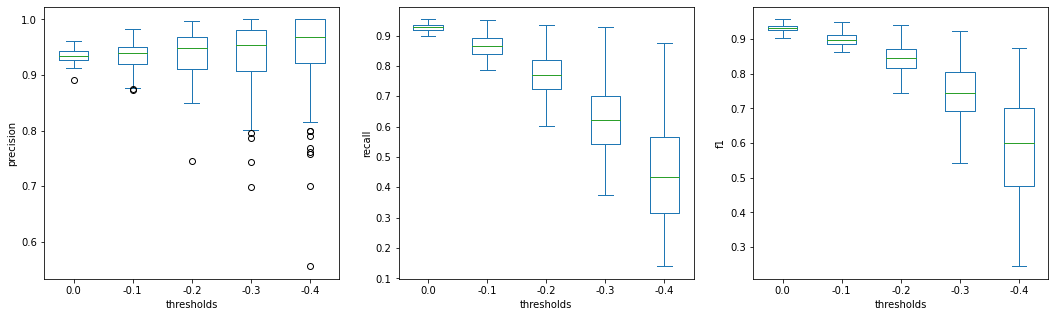

In [12]:
plt.figure(figsize=(18,5))
plt.subplot(131)
#pd.DataFrame(p_scoring['RF']).plot.box(ax=plt.gca(), ylabel='precision', **boxplotcolorprop('blue'))
pd.DataFrame(p_scoring['RF']).plot.box(ax=plt.gca(), ylabel='precision')
plt.xlabel('thresholds')
plt.subplot(132)
#pd.DataFrame(r_scoring['RF']).plot.box(ax=plt.gca(), ylabel='recall', **boxplotcolorprop('red'))
pd.DataFrame(r_scoring['RF']).plot.box(ax=plt.gca(), ylabel='recall')
plt.xlabel('thresholds')
plt.subplot(133)
#pd.DataFrame(f_scoring['RF']).plot.box(ax=plt.gca(), ylabel='f1', **boxplotcolorprop('green'))
pd.DataFrame(f_scoring['RF']).plot.box(ax=plt.gca(), ylabel='f1')
plt.xlabel('thresholds')
plt.show()

In [14]:
# WEIGHTED RANDOM FORREST

trials=tqdm(range(100))

for i in trials:
    X,y=gen_timeseries_dataset(n_samples=6_000,n_features=10,level=100,random_state=i)
    y_change=np.diff(y)
    y_change=y_change/y[:-1]*100
    X=np.diff(X,axis=0)
    
    for t in thresholds:
        y=(y_change<t).astype(int)
        X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,shuffle=False)
        model=RandomForestClassifier(n_estimators=100,random_state=33,n_jobs=-1,oob_score=True)
        model.fit(X_train,y_train)
        
        linear_reg=LogisticRegression()
        linear_reg.fit(model.oob_decision_function_,y_train)
        
        y_pred=linear_reg.predict(model.predict_proba(X_test))
        f_scoring['RF_STACK_OOB'][t].append(f1_score(y_test,y_pred))
        p_scoring['RF_STACK_OOB'][t].append(precision_score(y_test,y_pred))
        r_scoring['RF_STACK_OOB'][t].append(recall_score(y_test,y_pred))
    
    desc = scores2str(f_scoring['RF_STACK_OOB'], 'F1')
    trials.set_description(desc)

print(scores2str(p_scoring['RF_STACK_OOB'], 'Precision'))
print(scores2str(r_scoring['RF_STACK_OOB'], 'Recall'))
print(scores2str(f_scoring['RF_STACK_OOB'], 'F1'))

  0%|          | 0/100 [00:00<?, ?it/s]

Precision   | (0): 0.932 | (-0.1): 0.917 | (-0.2): 0.900 | (-0.3): 0.875 | (-0.4): 0.852
Recall      | (0): 0.931 | (-0.1): 0.895 | (-0.2): 0.841 | (-0.3): 0.759 | (-0.4): 0.633
F1          | (0): 0.931 | (-0.1): 0.905 | (-0.2): 0.866 | (-0.3): 0.804 | (-0.4): 0.703


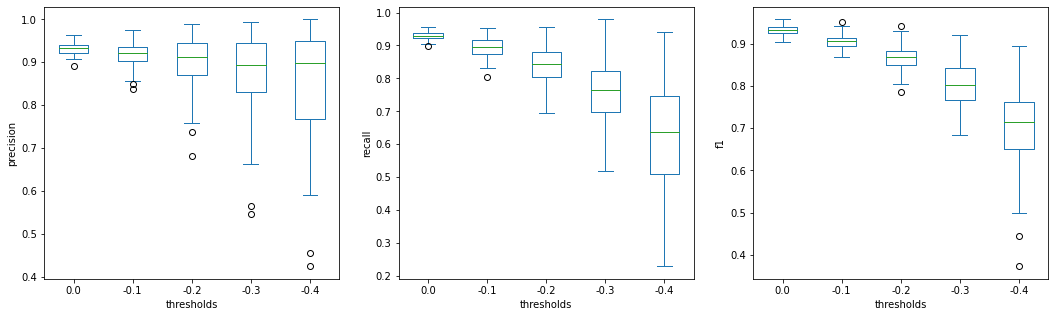

In [15]:
plt.figure(figsize=(18,5))
plt.subplot(131)
#pd.DataFrame(p_scoring['RF']).plot.box(ax=plt.gca(), ylabel='precision', **boxplotcolorprop('blue'))
pd.DataFrame(p_scoring['RF_STACK_OOB']).plot.box(ax=plt.gca(), ylabel='precision')
plt.xlabel('thresholds')
plt.subplot(132)
#pd.DataFrame(r_scoring['RF']).plot.box(ax=plt.gca(), ylabel='recall', **boxplotcolorprop('red'))
pd.DataFrame(r_scoring['RF_STACK_OOB']).plot.box(ax=plt.gca(), ylabel='recall')
plt.xlabel('thresholds')
plt.subplot(133)
#pd.DataFrame(f_scoring['RF']).plot.box(ax=plt.gca(), ylabel='f1', **boxplotcolorprop('green'))
pd.DataFrame(f_scoring['RF_STACK_OOB']).plot.box(ax=plt.gca(), ylabel='f1')
plt.xlabel('thresholds')
plt.show()

In [16]:
# WEIGHTED RANDOM FORREST

trials=tqdm(range(100))

for i in trials:
    X,y=gen_timeseries_dataset(n_samples=6_000,n_features=10,level=100,random_state=i)
    y_change=np.diff(y)
    y_change=y_change/y[:-1]*100
    X=np.diff(X,axis=0)
    
    for t in thresholds:
        y=(y_change<t).astype(int)
        X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,shuffle=False)
        model=LinearForestClassifier(Ridge(),n_estimators=100,random_state=33,n_jobs=-1)
        model.fit(X_train,y_train)
        
        y_pred=linear_reg.predict(model.predict_proba(X_test))
        f_scoring['LINEAR_RF'][t].append(f1_score(y_test,y_pred))
        p_scoring['LINEAR_RF'][t].append(precision_score(y_test,y_pred))
        r_scoring['LINEAR_RF'][t].append(recall_score(y_test,y_pred))
    
    desc = scores2str(f_scoring['LINEAR_RF'], 'F1')
    trials.set_description(desc)

print(scores2str(p_scoring['LINEAR_RF'], 'Precision'))
print(scores2str(r_scoring['LINEAR_RF'], 'Recall'))
print(scores2str(f_scoring['LINEAR_RF'], 'F1'))

  0%|          | 0/100 [00:00<?, ?it/s]

Precision   | (0): 0.929 | (-0.1): 0.916 | (-0.2): 0.902 | (-0.3): 0.883 | (-0.4): 0.855
Recall      | (0): 0.978 | (-0.1): 0.945 | (-0.2): 0.877 | (-0.3): 0.748 | (-0.4): 0.550
F1          | (0): 0.953 | (-0.1): 0.930 | (-0.2): 0.887 | (-0.3): 0.801 | (-0.4): 0.646


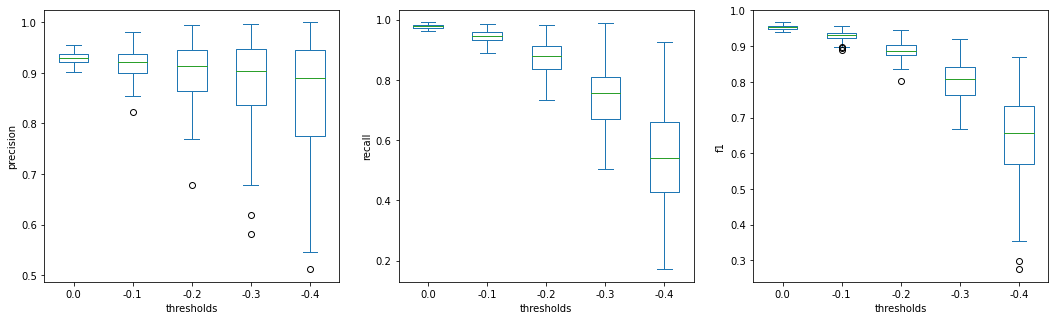

In [17]:
plt.figure(figsize=(18,5))
plt.subplot(131)
#pd.DataFrame(p_scoring['RF']).plot.box(ax=plt.gca(), ylabel='precision', **boxplotcolorprop('blue'))
pd.DataFrame(p_scoring['LINEAR_RF']).plot.box(ax=plt.gca(), ylabel='precision')
plt.xlabel('thresholds')
plt.subplot(132)
#pd.DataFrame(r_scoring['RF']).plot.box(ax=plt.gca(), ylabel='recall', **boxplotcolorprop('red'))
pd.DataFrame(r_scoring['LINEAR_RF']).plot.box(ax=plt.gca(), ylabel='recall')
plt.xlabel('thresholds')
plt.subplot(133)
#pd.DataFrame(f_scoring['RF']).plot.box(ax=plt.gca(), ylabel='f1', **boxplotcolorprop('green'))
pd.DataFrame(f_scoring['LINEAR_RF']).plot.box(ax=plt.gca(), ylabel='f1')
plt.xlabel('thresholds')
plt.show()

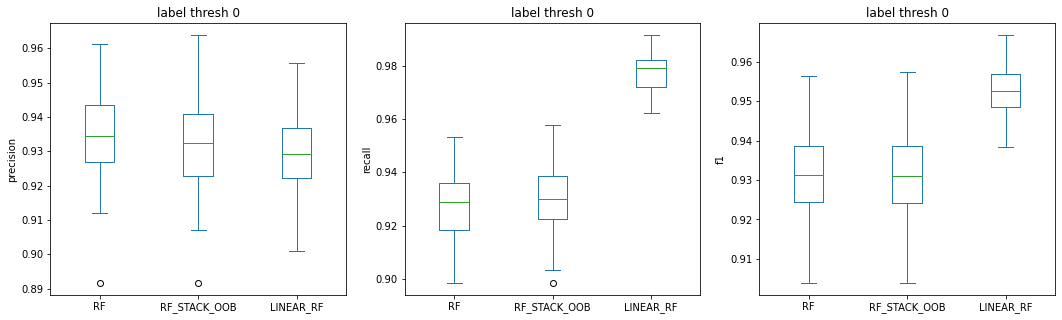

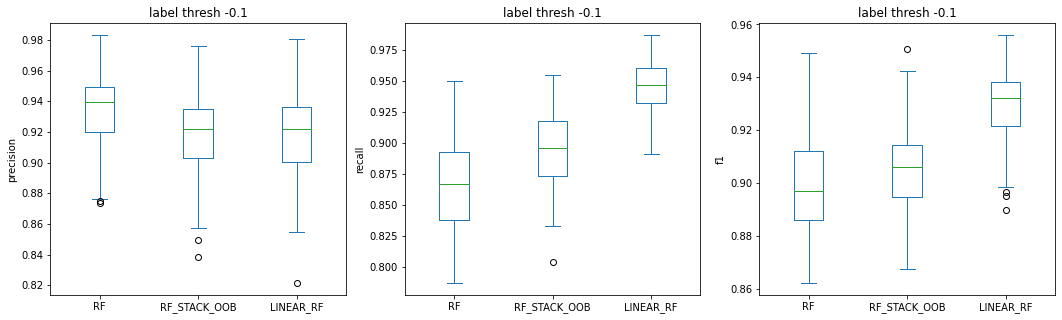

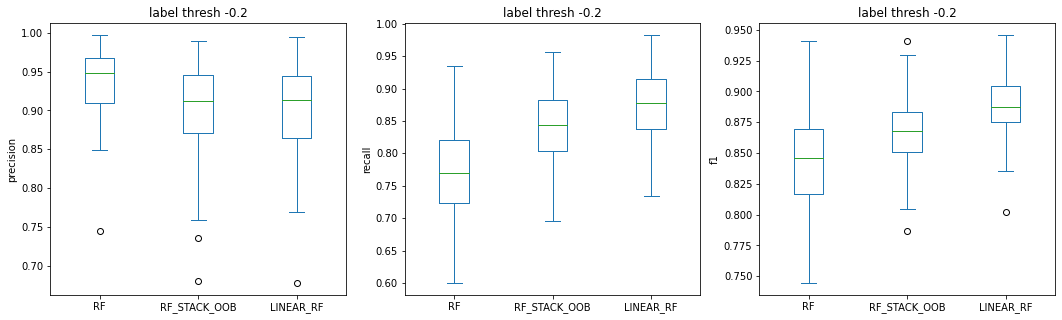

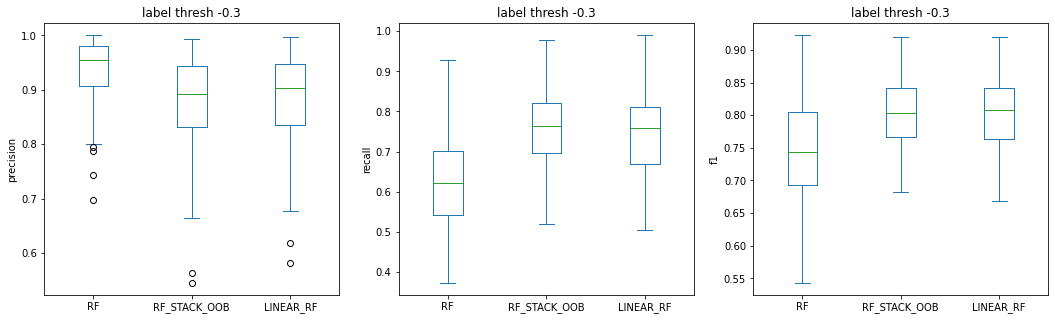

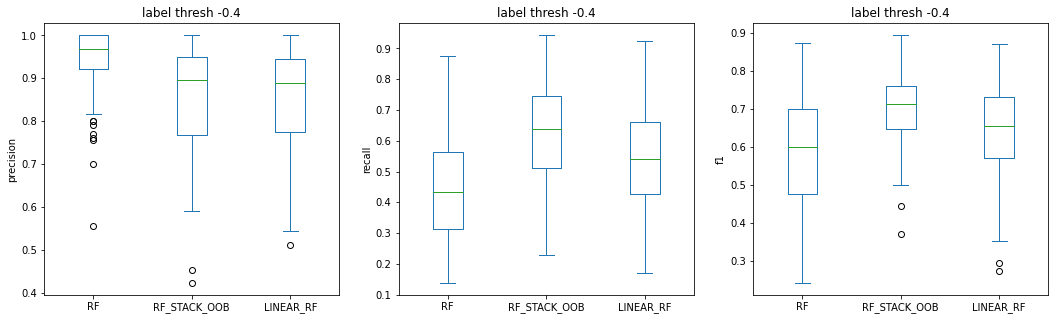

In [18]:
for t in thresholds: 
    plt.figure(figsize=(18,5))
    plt.subplot(131)
    pd.DataFrame({m: p_scoring[m][t] for m in models}).plot.box(
        ax=plt.gca(), title=f'label thresh {t}', ylabel='precision'
    )
    plt.subplot(132)
    pd.DataFrame({m: r_scoring[m][t] for m in models}).plot.box(
        ax=plt.gca(), title=f'label thresh {t}', ylabel='recall'
    )
    plt.subplot(133)
    pd.DataFrame({m: f_scoring[m][t] for m in models}).plot.box(
        ax=plt.gca(), title=f'label thresh {t}', ylabel='f1'
    )
    plt.show()
    print('\n\n')

## Linear Trees Classification - Data Shifts

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from lineartree import *
from sklearn.linear_model import *
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, GridSearchCV

from pandas.plotting import register_matplotlib_converters

In [20]:
### CREATE SYNTHETIC DATA ###

X,y = make_classification(n_samples=8000, n_features=20, n_classes=3, 
                          n_informative=4, n_redundant=6, shift=0,
                          random_state=0)

X.shape, y.shape
register_matplotlib_converters()

In [22]:
## STORE DATA IN DF ###

df = pd.DataFrame(X, columns=[f"c_{c}" for c in range(X.shape[1])], 
                  index=pd.date_range('2021', periods=X.shape[0], freq='D'))

print(df.shape)
df.head()

(8000, 20)


,c_0,c_1,c_2,c_3,c_4,c_5,c_6,c_7,c_8,c_9,c_10,c_11,c_12,c_13,c_14,c_15,c_16,c_17,c_18,c_19
2021-01-01,4.287691,-0.358809,0.777817,0.175833,0.248941,2.686354,0.037420,0.003614,-1.244712,2.302351,-0.627346,4.005909,-0.949230,1.996186,-2.124947,-0.856226,-0.177669,-0.866306,0.567518,-0.687878
2021-01-02,-2.444821,0.281751,0.769856,1.890554,0.485304,-1.640004,-1.567687,0.437817,2.605101,1.679222,-0.555384,-3.300566,1.002278,2.219537,1.202828,0.459995,0.377004,-0.091082,-0.468515,-1.105517
2021-01-03,2.199832,-0.728858,-0.851401,1.028180,0.538306,1.624893,-0.489566,0.543877,0.051013,2.013999,-0.843005,1.919138,-0.273925,2.204062,-1.350526,0.228423,-0.954840,-1.790186,1.938162,-0.229806
2021-01-04,-1.020253,0.697211,1.611068,1.249618,0.310183,-0.414572,-1.082014,0.693993,0.991894,0.407220,0.554988,-1.147604,1.706236,1.090488,0.216886,-0.611295,1.273114,-1.792371,-1.634992,-1.054940
2021-01-05,-0.176863,-1.076803,-0.917608,-1.604149,-1.446171,-1.617815,-0.539624,-0.225089,-1.074695,-0.271801,0.947266,-0.923235,-0.714952,-1.070699,1.405238,-0.207820,-0.402361,0.533625,0.698437,-0.298558


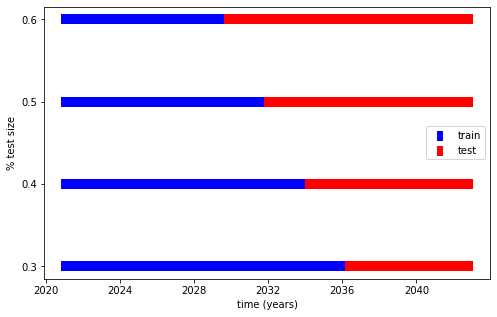

In [23]:
### CREATE AND SHOW TRAIN-TEST SCHEMA ###

test_size = [0.6, 0.5, 0.4, 0.3] 

plt.figure(figsize=(8,5))
for size in test_size:
        
    X_train, X_test = train_test_split(
        df.copy(), test_size=size, shuffle=False)
    
    if size == min(test_size):
        plt.scatter(X_train.index, [size]*len(X_train), 
                    marker='_', lw=10, c='blue', label='train')
        plt.scatter(X_test.index, [size]*len(X_test), 
                    marker='_', lw=10, c='red', label='test')
        plt.legend()
    else:
        plt.scatter(X_train.index, [size]*len(X_train), 
                    marker='_', lw=10, c='blue')
        plt.scatter(X_test.index, [size]*len(X_test), 
                    marker='_', lw=10, c='red')

plt.yticks(np.arange(max(test_size), min(test_size)-0.1, -0.1), test_size)
plt.ylabel('% test size'); plt.xlabel('time (years)'); plt.show()

In [24]:
### EMPTY DICT TO STORE RESULTS ###

results = {
    'DecisionTree': {},
    'LinearModel': {},
    'LinearTree': {},
    'Baseline': {}
}

In [25]:
### FIT MODELS AND STORE RESULTS ###

for size in test_size:
    
    X_train, X_test, y_train, y_test = train_test_split(
        df.copy(), y.copy(), test_size=size, shuffle=False)
    
    model = DummyClassifier(strategy='most_frequent')
    model.fit(X_train, y_train)
    
    results['Baseline'][size] = model.score(X_test, y_test)
    
    model = GridSearchCV(estimator=DecisionTreeClassifier(random_state=33), 
                     param_grid={'max_depth': [3, 6, 8, 10, None], 'min_samples_split': [6, 12, 18]}, 
                     n_jobs=-1, cv=3, refit=True)
    model.fit(X_train, y_train)
    
    results['DecisionTree'][size] = model.score(X_test, y_test)

    model = GridSearchCV(estimator=LinearTreeClassifier(RidgeClassifier()),
                         param_grid={'max_depth': [3, 6, 8], 'min_samples_split': [12, 18]}, 
                         n_jobs=-1, cv=3, refit=True)
    model.fit(X_train, y_train)
    
    results['LinearTree'][size] = model.score(X_test, y_test)
    
    model = GridSearchCV(estimator=RidgeClassifier(),
                         param_grid={'alpha': [1, 3, 6]}, 
                         n_jobs=-1, cv=3, refit=True)
    model.fit(X_train, y_train)
    
    results['LinearModel'][size] = model.score(X_test, y_test)

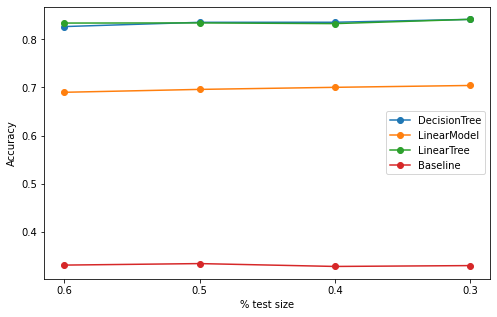

In [26]:
### PLOT RESULTS ###

plt.figure(figsize=(8,5))
for model in results:
    plt.plot(list(results[model].values()), label=model, marker='o')
    
plt.xticks(range(len(results[model])), results[model].keys())
plt.ylabel("Accuracy"); plt.xlabel("% test size")
plt.legend(); plt.show()

### Features Shifts

In [27]:
### STORE DATA IN DF ###

X,y = make_classification(n_samples=8000, n_features=20, n_classes=3, 
                          n_informative=4, n_redundant=6, shift=0,
                          random_state=0)

np.random.seed(0)
shift1 = np.random.randint(-3,3, (1,X.shape[1]))
shift2 = np.random.randint(1,6, (1,X.shape[1]))

X[int(X.shape[0]*0.5):int(X.shape[0]*0.8)] += shift1
X[int(X.shape[0]*0.8):] += shift2

df = pd.DataFrame(X, columns=[f"c_{c}" for c in range(X.shape[1])], 
                  index=pd.date_range('2021', periods=X.shape[0], freq='D'))

print(df.shape)
df.head()

(8000, 20)


,c_0,c_1,c_2,c_3,c_4,c_5,c_6,c_7,c_8,c_9,c_10,c_11,c_12,c_13,c_14,c_15,c_16,c_17,c_18,c_19
2021-01-01,4.287691,-0.358809,0.777817,0.175833,0.248941,2.686354,0.037420,0.003614,-1.244712,2.302351,-0.627346,4.005909,-0.949230,1.996186,-2.124947,-0.856226,-0.177669,-0.866306,0.567518,-0.687878
2021-01-02,-2.444821,0.281751,0.769856,1.890554,0.485304,-1.640004,-1.567687,0.437817,2.605101,1.679222,-0.555384,-3.300566,1.002278,2.219537,1.202828,0.459995,0.377004,-0.091082,-0.468515,-1.105517
2021-01-03,2.199832,-0.728858,-0.851401,1.028180,0.538306,1.624893,-0.489566,0.543877,0.051013,2.013999,-0.843005,1.919138,-0.273925,2.204062,-1.350526,0.228423,-0.954840,-1.790186,1.938162,-0.229806
2021-01-04,-1.020253,0.697211,1.611068,1.249618,0.310183,-0.414572,-1.082014,0.693993,0.991894,0.407220,0.554988,-1.147604,1.706236,1.090488,0.216886,-0.611295,1.273114,-1.792371,-1.634992,-1.054940
2021-01-05,-0.176863,-1.076803,-0.917608,-1.604149,-1.446171,-1.617815,-0.539624,-0.225089,-1.074695,-0.271801,0.947266,-0.923235,-0.714952,-1.070699,1.405238,-0.207820,-0.402361,0.533625,0.698437,-0.298558


Text(0.5, 0, 'time (years)')

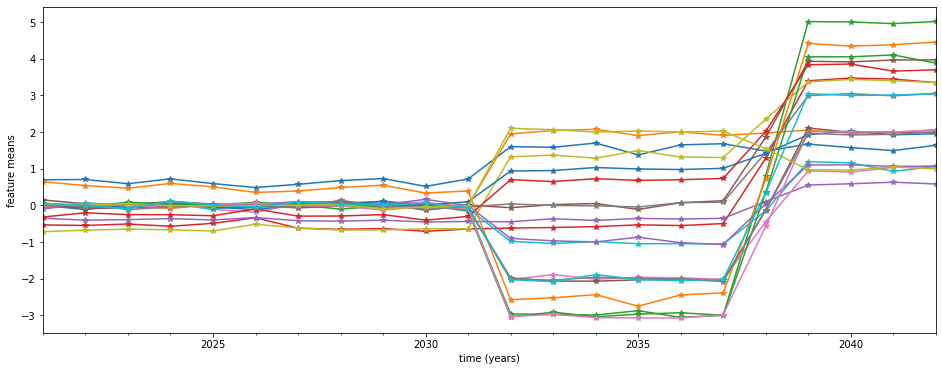

In [28]:
### FEATURE DISTRIBUTIONS OVER TIME ###

df.groupby(df.index.year).mean().set_index(pd.to_datetime(df.index.year.unique(), format='%Y')).plot(
    legend=False, figsize=(16,6), style='-*')
plt.ylabel('feature means'); plt.xlabel('time (years)')

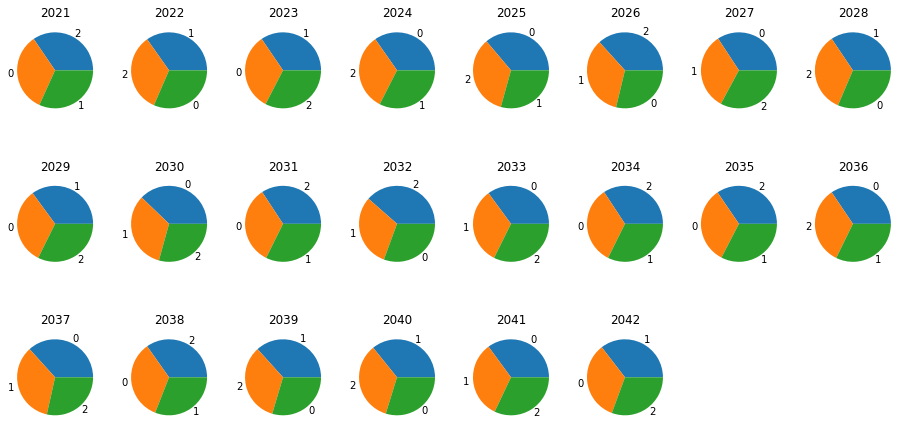

In [29]:
### LABEL DISTRIBUTION OVER TIME ###

plt.figure(figsize=(16,8))

for i,(year,g) in enumerate(pd.Series(y, name='label').groupby(df.index.year)):
    
    plt.subplot(3,8,i+1)
    g.value_counts().plot.pie(title=year)
    plt.axis('off')

In [30]:
### EMPTY DICT TO STORE RESULTS ###

results = {
    'DecisionTree': {},
    'LinearModel': {},
    'LinearTree': {},
    'Baseline': {}
}

In [31]:
### FIT MODELS AND STORE RESULTS ###

for size in test_size:
    
    X_train, X_test, y_train, y_test = train_test_split(
        df.copy(), y.copy(), test_size=size, shuffle=False)
    
    model = DummyClassifier(strategy='most_frequent')
    model.fit(X_train, y_train)
    
    results['Baseline'][size] = model.score(X_test, y_test)
    
    model = GridSearchCV(estimator=DecisionTreeClassifier(random_state=33), 
                     param_grid={'max_depth': [3, 6, 8, 10, None], 'min_samples_split': [6, 12, 18]}, 
                     n_jobs=-1, cv=3, refit=True)
    model.fit(X_train, y_train)
    
    results['DecisionTree'][size] = model.score(X_test, y_test)

    model = GridSearchCV(estimator=LinearTreeClassifier(RidgeClassifier()),
                         param_grid={'max_depth': [3, 6, 8], 'min_samples_split': [12, 18]}, 
                         n_jobs=-1, cv=3, refit=True)
    model.fit(X_train, y_train)
    
    results['LinearTree'][size] = model.score(X_test, y_test)
    
    model = GridSearchCV(estimator=RidgeClassifier(),
                         param_grid={'alpha': [1, 3, 6]}, 
                         n_jobs=-1, cv=3, refit=True)
    model.fit(X_train, y_train)
    
    results['LinearModel'][size] = model.score(X_test, y_test)

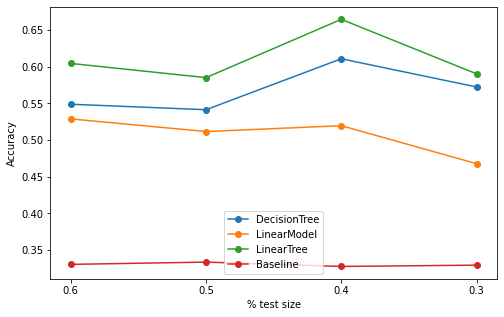

In [32]:
### PLOT RESULTS ###

plt.figure(figsize=(8,5))
for model in results:
    plt.plot(list(results[model].values()), label=model, marker='o')
    
plt.xticks(range(len(results[model])), results[model].keys())
plt.ylabel("Accuracy"); plt.xlabel("% test size")
plt.legend(); plt.show()

### Label Shifts

In [33]:
### CREATE SYNTHETIC DATA ###

X,y = make_classification(n_samples=8000, n_features=20, n_classes=2, 
                          n_informative=4, n_redundant=6, shift=0,
                          random_state=0)
_,y1 = make_classification(n_samples=8000, n_features=20, n_classes=2, 
                            n_informative=4, n_redundant=6, shift=0,
                            weights=[0.6, 0.4],
                            random_state=0)
_,y2 = make_classification(n_samples=8000, n_features=20, n_classes=2, 
                            n_informative=4, n_redundant=6, shift=0,
                            weights=[0.7, 0.3],
                            random_state=0)

y[int(y.shape[0]*0.5):int(y.shape[0]*0.8)] = y1[int(y.shape[0]*0.5):int(y.shape[0]*0.8)]
y[int(y.shape[0]*0.8):] = y2[int(y.shape[0]*0.8):]

df = pd.DataFrame(X, columns=[f"c_{c}" for c in range(X.shape[1])], 
                  index=pd.date_range('2021', periods=X.shape[0], freq='D'))

print(df.shape)
df.head()

(8000, 20)


,c_0,c_1,c_2,c_3,c_4,c_5,c_6,c_7,c_8,c_9,c_10,c_11,c_12,c_13,c_14,c_15,c_16,c_17,c_18,c_19
2021-01-01,0.821383,1.161708,2.831166,1.587163,1.054534,1.296977,-3.709026,-0.907038,-1.526936,1.130235,-0.866657,-1.628032,0.474710,2.570521,-0.585179,1.312589,-2.265808,0.414355,-0.650578,-3.751353
2021-01-02,1.443540,3.187349,0.923683,0.394118,-2.172413,-0.215947,0.666056,1.716370,0.537723,-1.417419,0.931193,1.589129,0.351800,1.497274,-0.756063,0.541655,-1.345804,-1.151544,-1.350107,-0.817080
2021-01-03,0.534494,1.087557,1.497025,0.668065,-0.914374,-1.421591,1.495214,0.254417,1.001146,0.053116,1.183041,0.726687,-0.107988,-3.046624,0.660347,0.282711,-0.196165,0.638087,0.886149,-0.508524
2021-01-04,0.055107,-0.251383,0.413238,0.460047,0.339353,-1.481324,1.303584,0.336805,2.286715,0.200445,-0.222899,0.708315,-0.945581,1.791337,-1.795334,1.193433,0.134012,0.082601,-0.766660,0.100024
2021-01-05,1.540019,3.463820,1.272690,-0.784644,-2.924575,-1.658141,2.712342,0.485971,0.659250,-1.555661,-0.718680,2.470681,0.309902,1.352404,1.798274,0.535998,-0.835954,-0.103250,0.518354,-0.199001


Text(0.5, 0, 'time (years)')

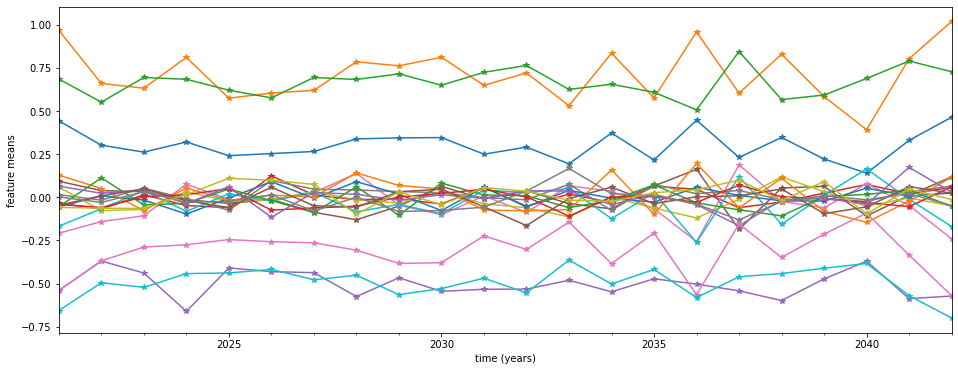

In [34]:
### FEATURE DISTRIBUTIONS OVER TIME ###

df.groupby(df.index.year).mean().set_index(pd.to_datetime(df.index.year.unique(), format='%Y')).plot(
    legend=False, figsize=(16,6), style='-*')
plt.ylabel('feature means'); plt.xlabel('time (years)')

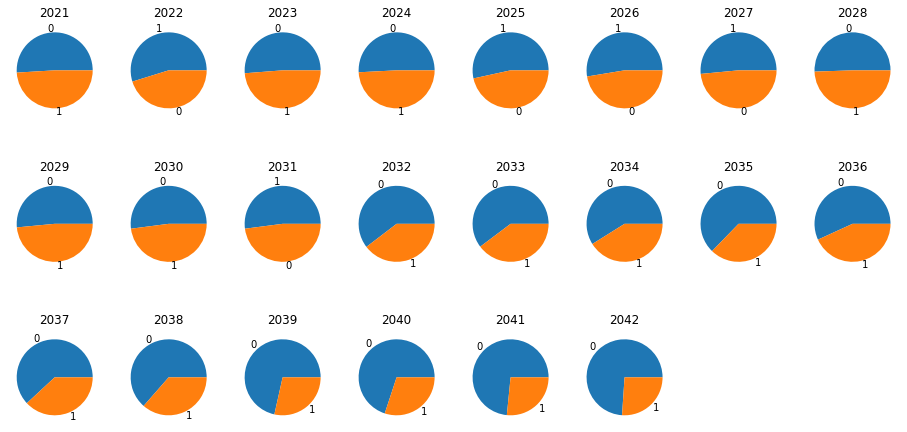

In [35]:
### LABEL DISTRIBUTIONS OVER TIME ###

plt.figure(figsize=(16,8))

for i,(year,g) in enumerate(pd.Series(y, name='label').groupby(df.index.year)):
    
    plt.subplot(3,8,i+1)
    g.value_counts().plot.pie(title=year)
    plt.axis('off')

In [36]:
### EMPTY DICT TO STORE RESULTS ###

results = {
    'DecisionTree': {},
    'LinearModel': {},
    'LinearTree': {},
    'Baseline': {}
}

In [37]:
### FIT MODELS AND STORE RESULTS ###

for size in test_size:
    
    X_train, X_test, y_train, y_test = train_test_split(
        df.copy(), y.copy(), test_size=size, shuffle=False)
    
    model = DummyClassifier(strategy='most_frequent')
    model.fit(X_train, y_train)
    
    results['Baseline'][size] = model.score(X_test, y_test)
    
    model = GridSearchCV(estimator=DecisionTreeClassifier(random_state=33), 
                     param_grid={'max_depth': [3, 6, 8, 10, None], 'min_samples_split': [6, 12, 18]}, 
                     n_jobs=-1, cv=3, refit=True)
    model.fit(X_train, y_train)
    
    results['DecisionTree'][size] = model.score(X_test, y_test)

    model = GridSearchCV(estimator=LinearTreeClassifier(RidgeClassifier()),
                         param_grid={'max_depth': [3, 6, 8], 'min_samples_split': [12, 18]}, 
                         n_jobs=-1, cv=3, refit=True)
    model.fit(X_train, y_train)
    
    results['LinearTree'][size] = model.score(X_test, y_test)
    
    model = GridSearchCV(estimator=RidgeClassifier(),
                         param_grid={'alpha': [1, 3, 6]}, 
                         n_jobs=-1, cv=3, refit=True)
    model.fit(X_train, y_train)
    
    results['LinearModel'][size] = model.score(X_test, y_test)

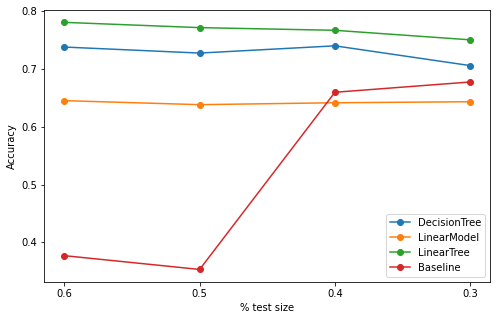

In [38]:
### PLOT RESULTS ###

plt.figure(figsize=(8,5))
for model in results:
    plt.plot(list(results[model].values()), label=model, marker='o')
plt.xticks(range(len(results[model])), results[model].keys())
plt.ylabel("Accuracy"); plt.xlabel("% test size")
plt.legend(); plt.show()

### Explainable AI with Linear Trees

If you are trying to priorize explainable over accuracy, the best approach is to select simple models. The best choose would be either Linear Models or Decision Trees.  

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from lineartree import *
from sklearn.linear_model import *
from sklearn.model_selection import train_test_split, GridSearchCV

import warnings
warnings.filterwarnings("ignore")

In [2]:
df=pd.read_csv('cs-training.csv',index_col=0)
print(df.shape)
df.head()

(150000, 11)


,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [3]:
X,y=df.copy().drop('SeriousDlqin2yrs',axis=1),df['SeriousDlqin2yrs'].copy()
X.fillna(X.mean(),inplace=True)

In [4]:
model=LinearTreeClassifier(RidgeClassifier(),max_depth=5,min_samples_leaf=1500,max_bins=20)
model.fit(X,y)

LinearTreeClassifier(base_estimator=RidgeClassifier(), max_bins=20,
                     min_samples_leaf=1500)

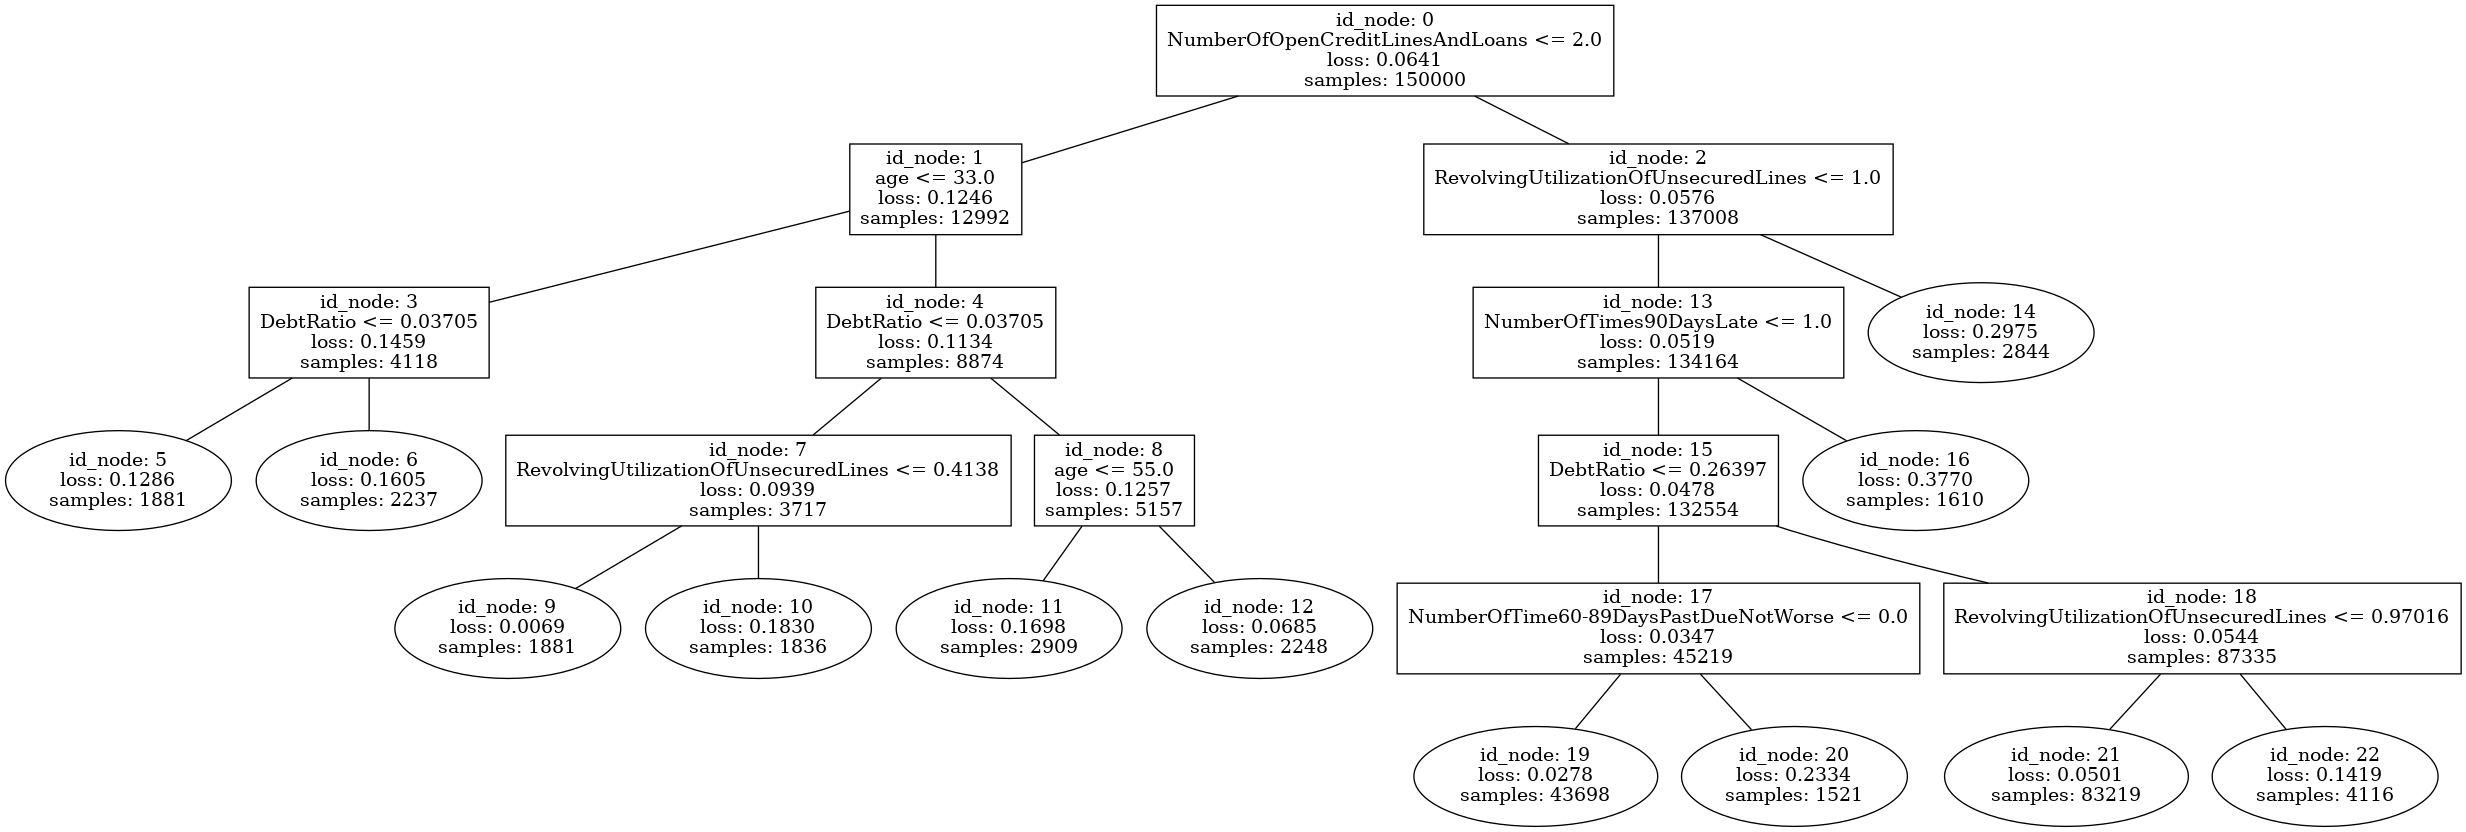

In [5]:
# Plot the tree structure
model.plot_model(feature_names=X.columns)

In [14]:
# Define Utility func to Extract Rules:

def get_rules(model,feature_names=None):
    summary=model.summary(feature_names=feature_names)
    leaves=model.summary(only_leaves=True).keys()
    rules={}
    
    for leaf in leaves:
        final_leaf=leaf
        conditions=[]
        while leaf != 0:
            for l,info, in summary.items():
                if 'children' in info:
                    if leaf in info['children']:
                        th=info['th']
                        col=(info['col'] if feature_names is not None else f"X[{info['col']}]")
                        direct='<=' if leaf==info['children'][0] else '>'
                        cond=f'({col} {direct} {th})'
                        conditions.append(cond)
                        leaf=l
        conditions=list(reversed(conditions))
        rules[f'leaf {final_leaf}']='AND'.join(conditions)
        
    return rules

In [15]:
rules = get_rules(model, X.columns)
rules

{'leaf 5': '(NumberOfOpenCreditLinesAndLoans <= 2.0)AND(age <= 33.0)AND(DebtRatio <= 0.03705)',
 'leaf 6': '(NumberOfOpenCreditLinesAndLoans <= 2.0)AND(age <= 33.0)AND(DebtRatio > 0.03705)',
 'leaf 9': '(NumberOfOpenCreditLinesAndLoans <= 2.0)AND(age > 33.0)AND(DebtRatio <= 0.03705)AND(RevolvingUtilizationOfUnsecuredLines <= 0.4138)',
 'leaf 10': '(NumberOfOpenCreditLinesAndLoans <= 2.0)AND(age > 33.0)AND(DebtRatio <= 0.03705)AND(RevolvingUtilizationOfUnsecuredLines > 0.4138)',
 'leaf 11': '(NumberOfOpenCreditLinesAndLoans <= 2.0)AND(age > 33.0)AND(DebtRatio > 0.03705)AND(age <= 55.0)',
 'leaf 12': '(NumberOfOpenCreditLinesAndLoans <= 2.0)AND(age > 33.0)AND(DebtRatio > 0.03705)AND(age > 55.0)',
 'leaf 19': '(NumberOfOpenCreditLinesAndLoans > 2.0)AND(RevolvingUtilizationOfUnsecuredLines <= 1.0)AND(NumberOfTimes90DaysLate <= 1.0)AND(DebtRatio <= 0.26397)AND(NumberOfTime60-89DaysPastDueNotWorse <= 0.0)',
 'leaf 20': '(NumberOfOpenCreditLinesAndLoans > 2.0)AND(RevolvingUtilizationOfUnsecur

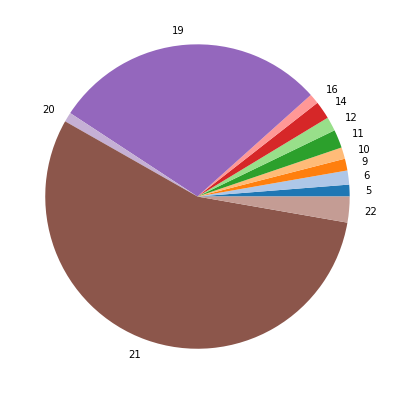

In [7]:
### COUNT HOW MANY TRAINING SAMPLES IN EACH LEAF ###

leaves = model.apply(X)
leaves_count = pd.value_counts(leaves).sort_index()
leaves_count.name = 'counts'

plt.figure(figsize=(7,7))
palette = plt.get_cmap('tab20').colors
plt.pie(leaves_count, labels=leaves_count.index, colors=palette)
plt.show()

Each leaf contains also a fitted Linear Model. We are building a Linear Tree, and the splits are evaluated considering the weighted sum of the training losses from left and right child candidates. We end having a fitted Linear Model in each leaf that predicts all the samples that satisfy a given set of decision rules.

At this point, we can inspect the results. Querying the Linear Models, we extract the coefficients and see the impact of each variable in the leaves. This is not all. We can also obtain the set of decision rules built during training. They are useful to identify in which leaf a given sample falls. From the combination of decision rules and the coefficients, we have a complete overview of the decision path followed by our model.

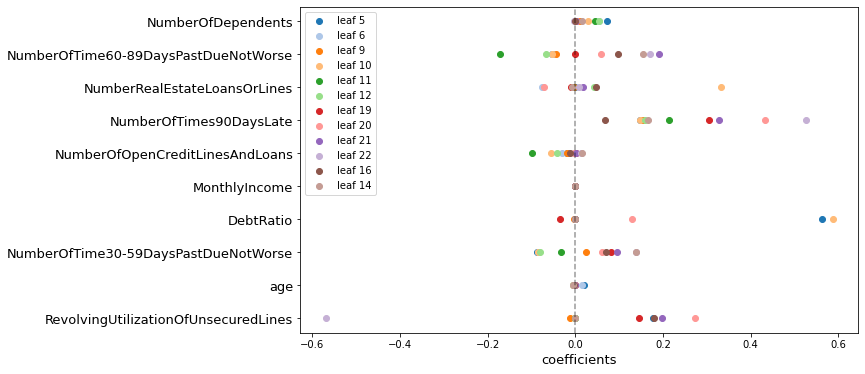

In [8]:
### PLOT COEFFICIENTS FROM LINEAR MODELS IN LEAVES ###

plt.figure(figsize=(10,6))
for _,(i,leave) in enumerate(model.summary(only_leaves=True).items()):
    coef_ = leave['models'].coef_[0]
    plt.scatter(coef_, range(X.shape[1]), label='leaf {}'.format(i), c=[palette[_%len(palette)]])

plt.axvline(0, linestyle='--', c='black', alpha=0.4)
plt.yticks(range(X.shape[1]), X.columns, size=13)
plt.xlabel('coefficients', size=13); plt.legend(); plt.show()   

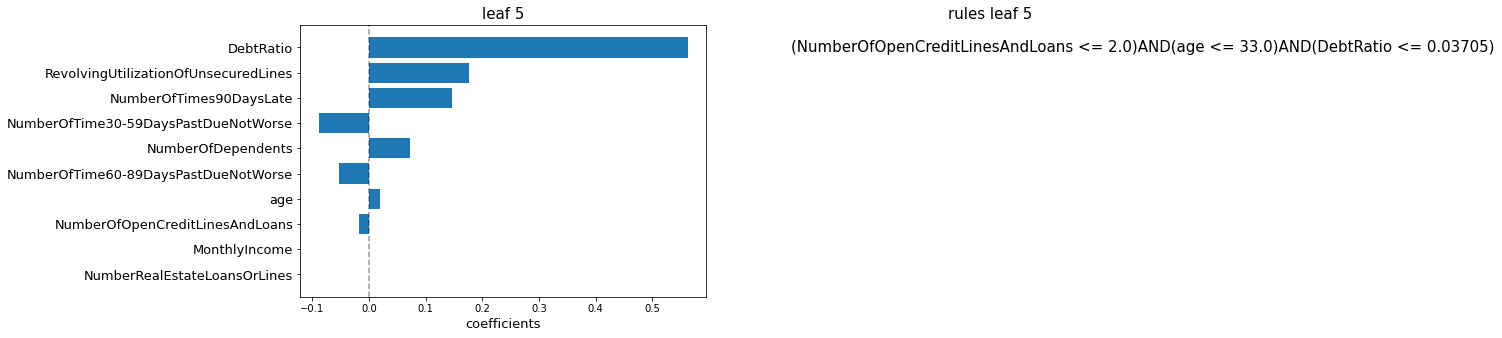

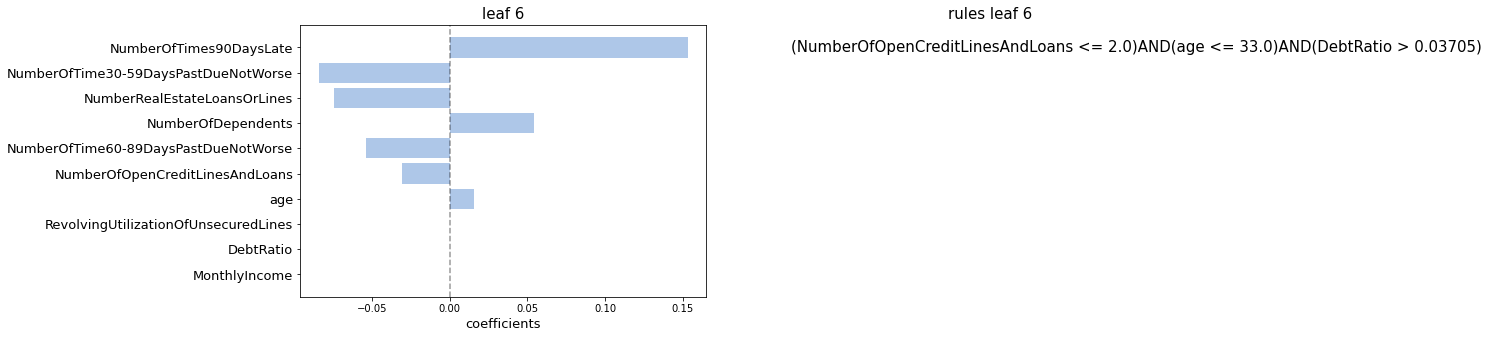

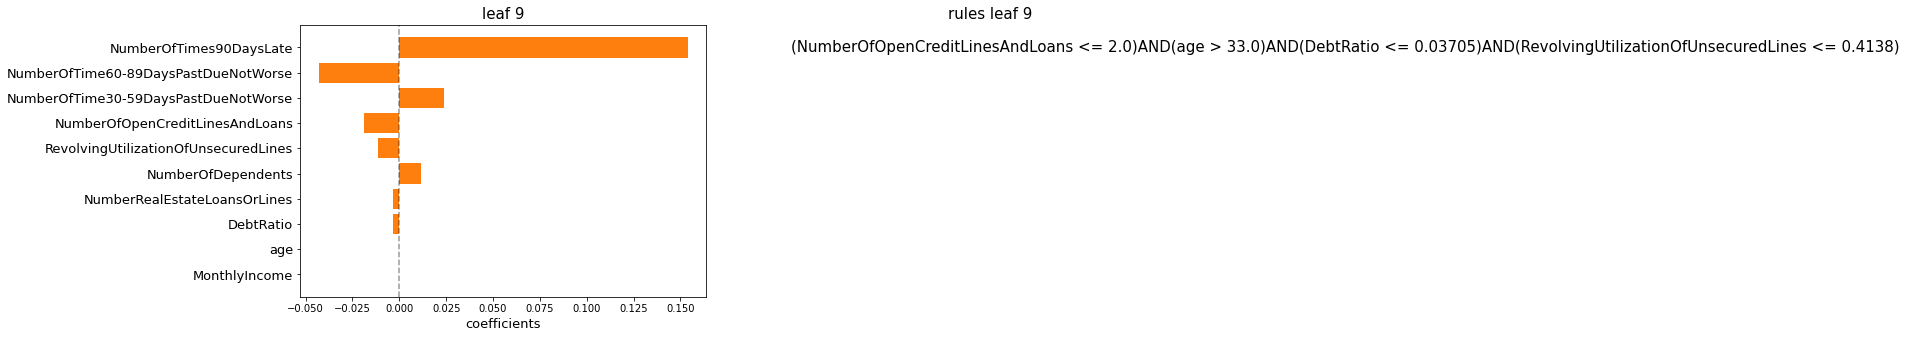

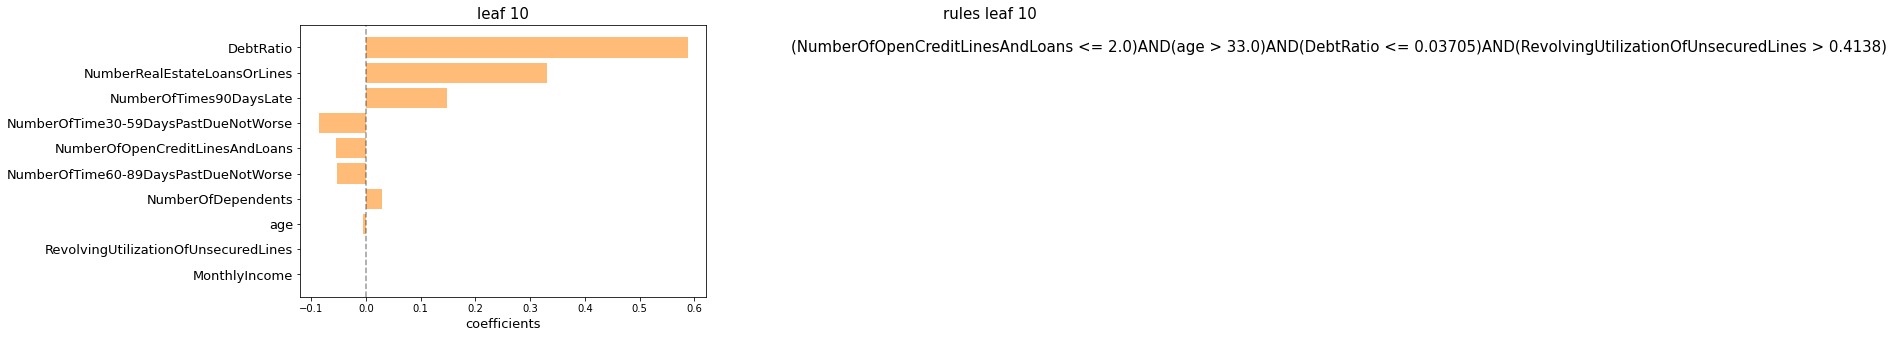

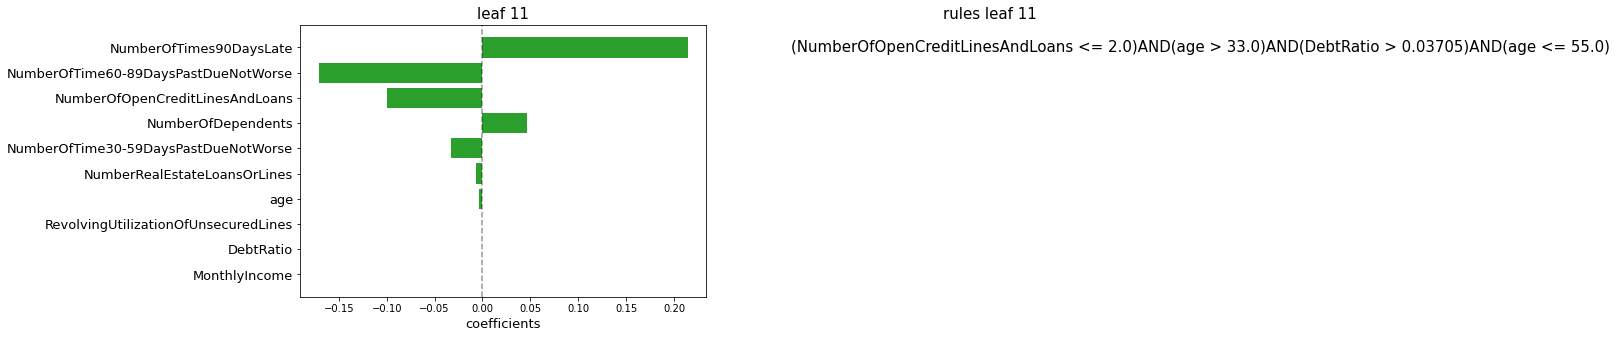

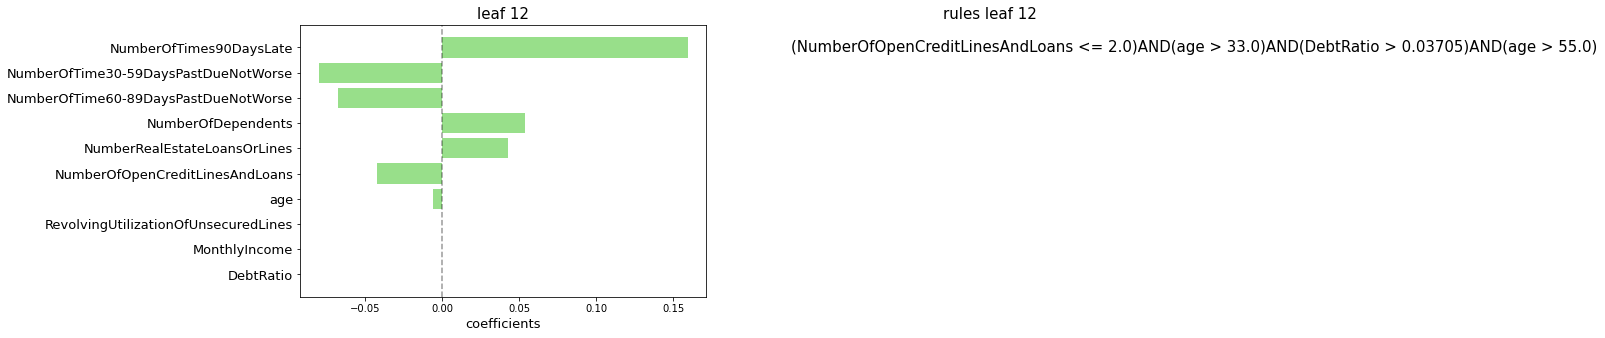

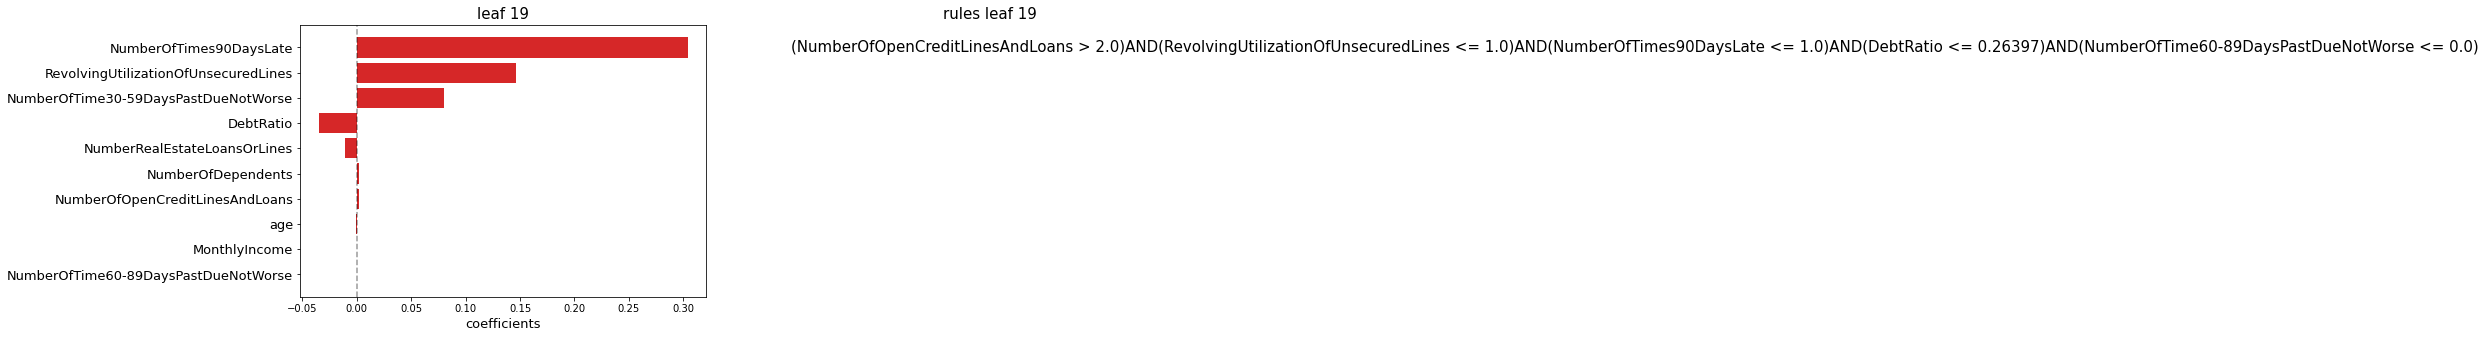

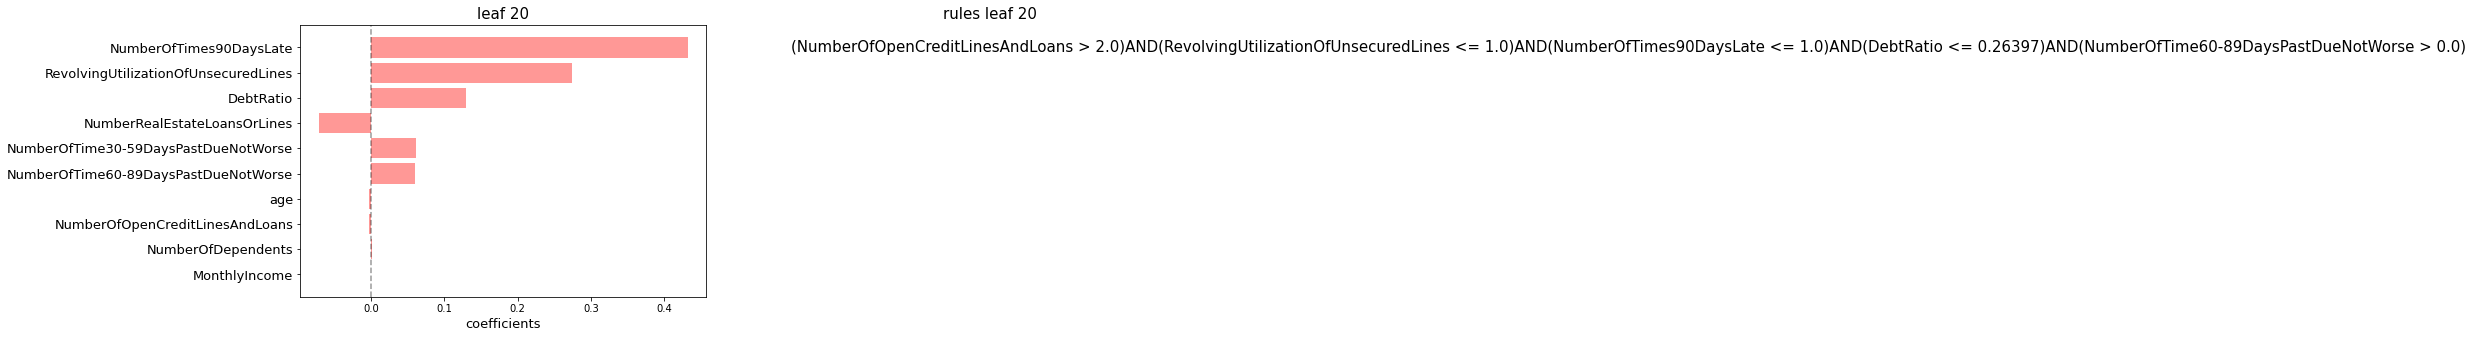

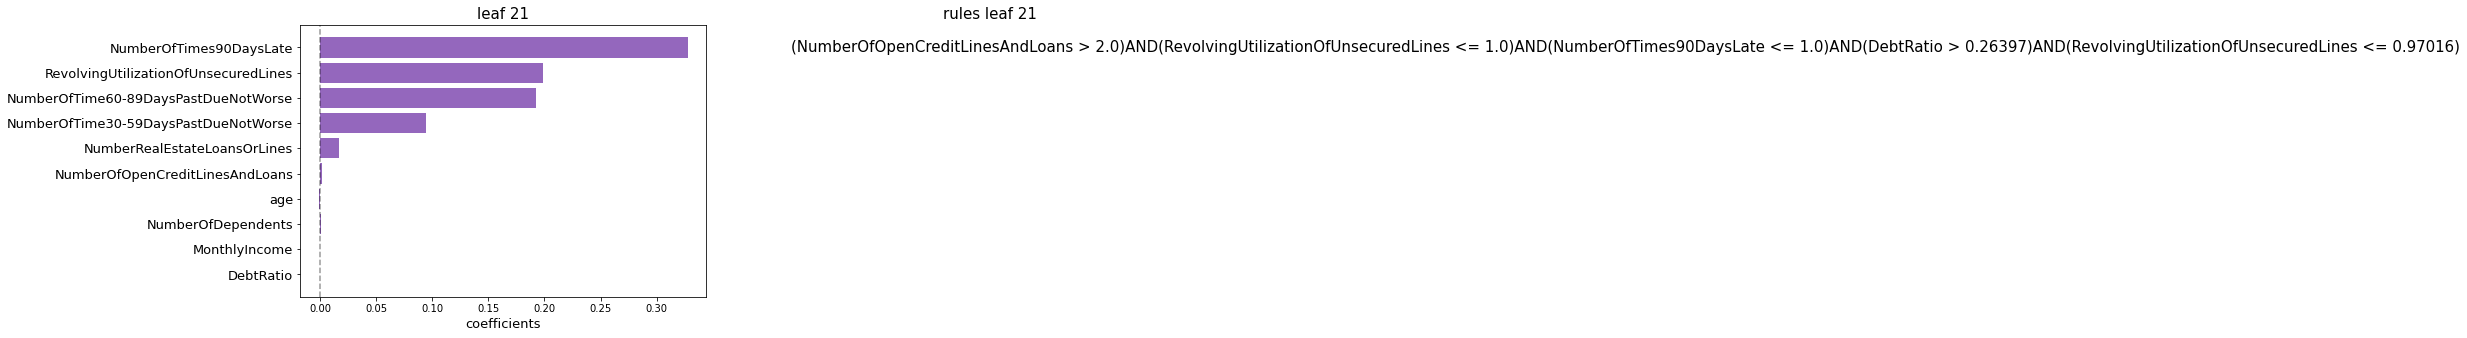

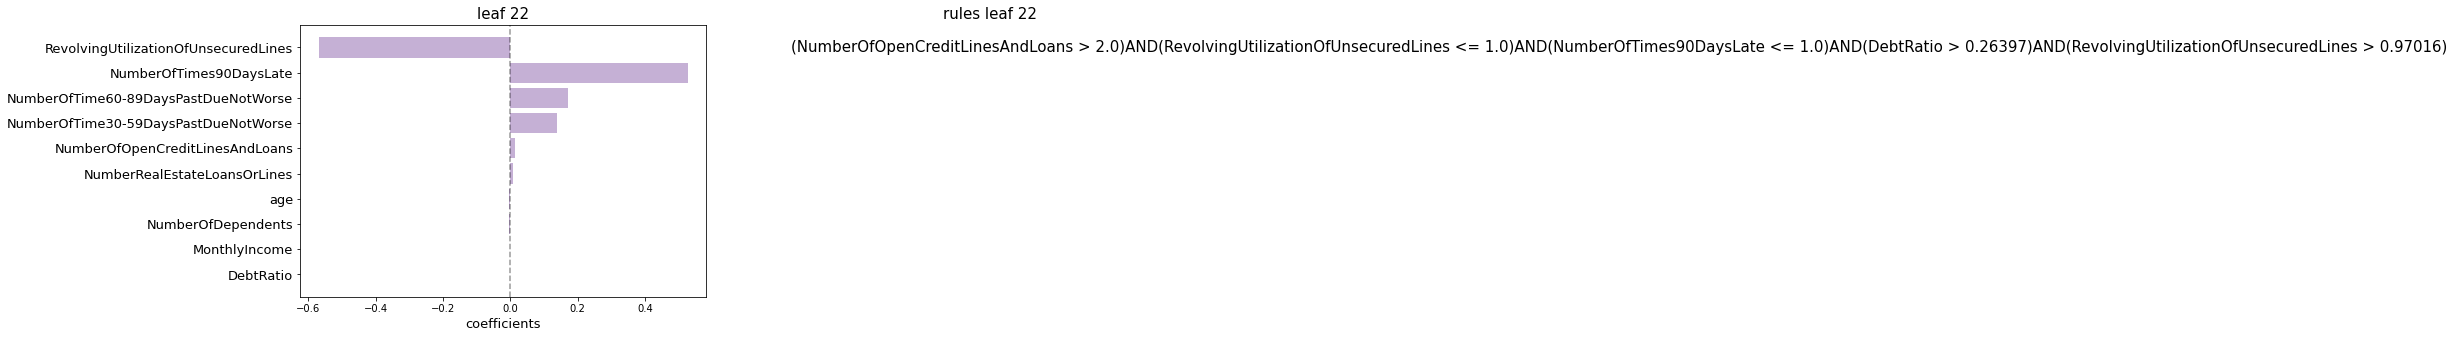

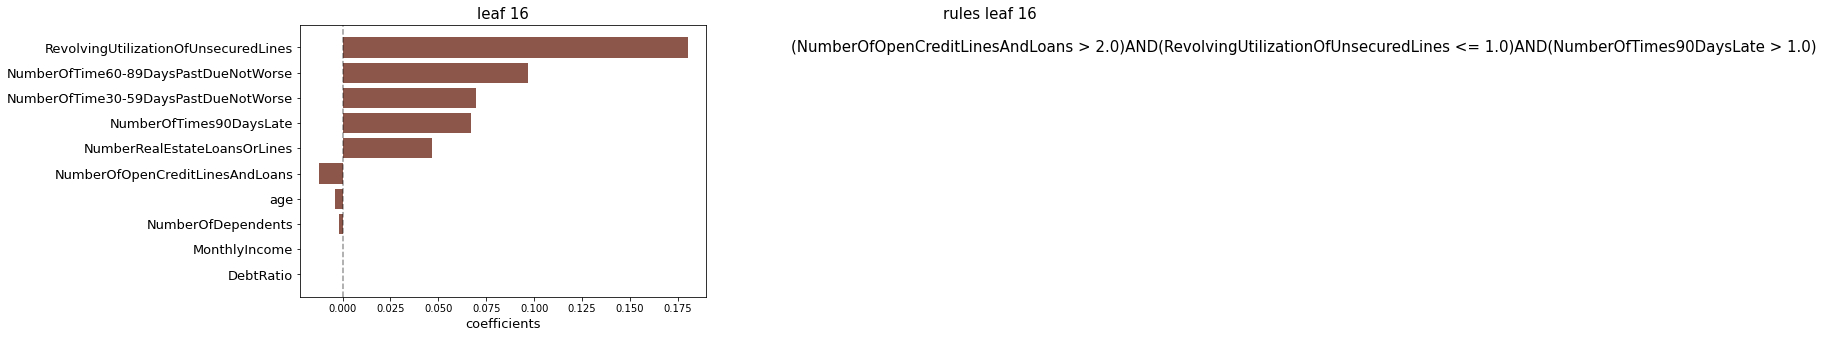

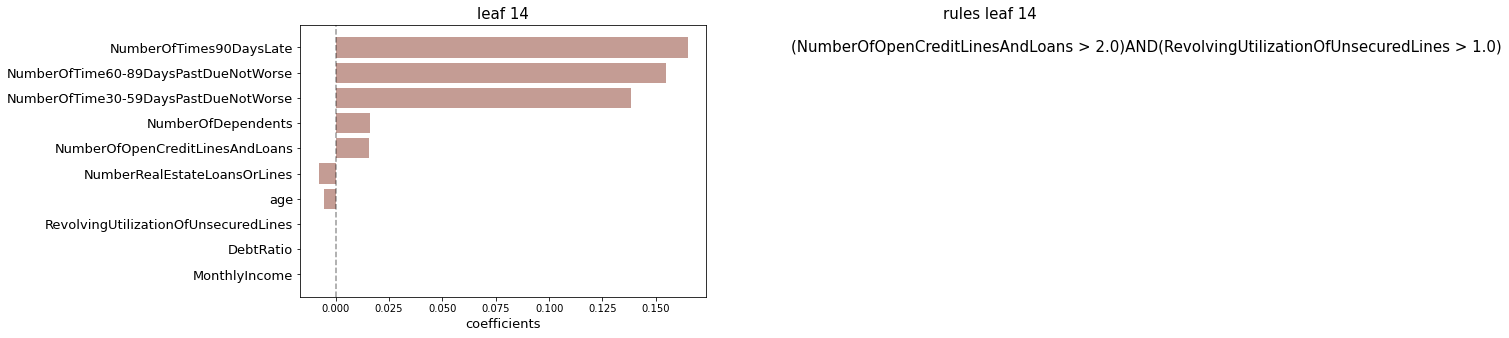

In [16]:
### PLOT COEFFICIENTS FROM LINEAR MODELS AND DECISION RULES IN EACH LEAF ###

for _,(i,leaf) in enumerate(model.summary(only_leaves=True).items()):
    
    if hasattr(leaf['models'], 'coef_'):
        coef_ = leaf['models'].coef_[0]
        order = np.argsort(np.abs(coef_))
    else:
        coef_ = np.zeros((X.shape[1],))
        order = np.arange(X.shape[1])
        
    text = rules['leaf {}'.format(i)].split(' AND ')
    
    plt.figure(figsize=(16,5))
    
    plt.subplot(121)
    plt.axvline(0, linestyle='--', c='black', alpha=0.4)
    plt.barh(range(X.shape[1]), coef_[order], color=[palette[_%len(palette)]])
    plt.yticks(range(X.shape[1]), X.columns[order], size=13)
    plt.title('leaf {}'.format(i), size=15); plt.xlabel('coefficients', size=13)
    
    plt.subplot(122)
    __ = 0.1
    for rule in text:
        rule = rule if rule == text[-1] else rule + ' AND'
        plt.text(0.01, 1-__, rule, size=15)
        __ += 0.1
    plt.title('rules leaf {}'.format(i), size=15); plt.axis('off')   
    
    plt.show()

## Linear Forrest for Regression

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from lineartree import LinearForestRegressor

from sklearn.datasets import make_regression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, train_test_split

In [19]:
def create_target(X, noise=0, add_trend=False):

    if add_trend:
        trend_smooth_lower = np.random.uniform(-1.8,-0.5, X.shape[1])
        trend_smooth_upper = np.random.uniform(0.4,1, X.shape[1])
        trend = np.log(1 + np.exp(2 * np.linspace(trend_smooth_lower, trend_smooth_upper, X.shape[0])))
        trend = pd.DataFrame(trend, columns=X.columns)
        X = X + trend

    y = (
          X['linear_1'] +
          X['linear_2']*3 + 
          (X['notlinear_square'] ** 2)/3 + 
          np.cos(3 * X['notlinear_cos']) + 
          (X['interaction_1'] * X['interaction_2'] * X['interaction_3'])/3
        )

    if noise > 0:
        y += np.random.normal(scale=noise, size=X.shape[0])

    return (X, y, trend) if add_trend else (X, y)

In [20]:
feature_names = [
   'linear_1',
   'linear_2',           
   'notlinear_square',  
   'notlinear_cos',    
   'interaction_1',    
   'interaction_2',    
   'interaction_3',    
   'noise_1',          
   'noise_2',         
   'noise_3',         
   'noise_4',         
   'noise_5'
]

np.random.seed(33)
X = pd.DataFrame(np.random.normal(size=(8_000, len(feature_names))), columns=feature_names)
X, y = create_target(X, noise=2, add_trend=False)
X_trend, y_trend, trend = create_target(X, noise=2, add_trend=True)

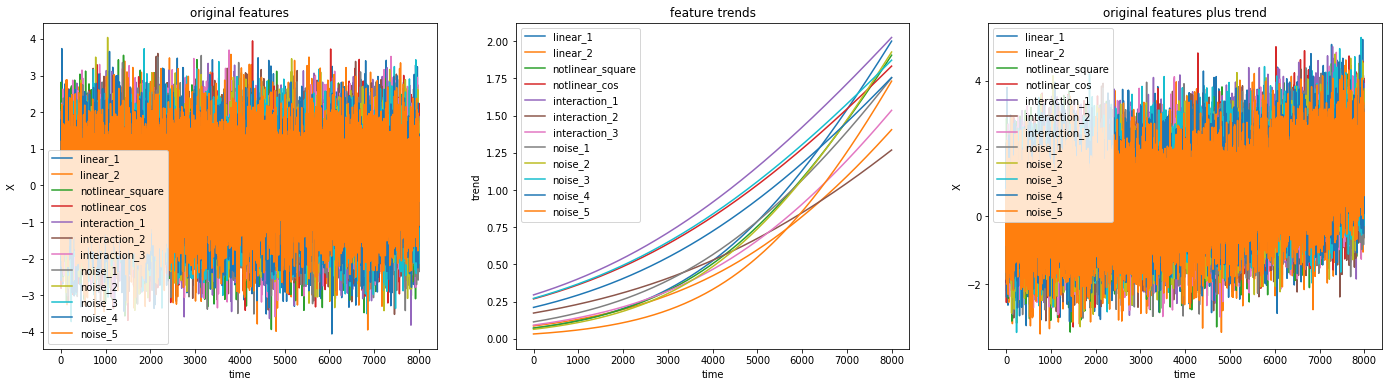

In [21]:
plt.figure(figsize=(24,6))

plt.subplot(131)
X.plot(ax=plt.gca()) 
plt.ylabel('X'); plt.xlabel('time'); plt.title('original features')

plt.subplot(132)
trend.plot(ax=plt.gca())
plt.ylabel('trend'); plt.xlabel('time'); plt.title('feature trends')

plt.subplot(133)
X_trend.plot(ax=plt.gca())
plt.ylabel('X'); plt.xlabel('time'); plt.title('original features plus trend')
plt.show()

In [22]:
test_size = [0.6, 0.5, 0.4, 0.3]

results_without_trend = {}
results_with_trend = {}

In [23]:
### FITTING RANDOM FOREST W/O TREND ###

results_without_trend['RandomForest'] = {}

for i in test_size:

    X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=i)

    model = GridSearchCV(
      RandomForestRegressor(random_state=33),
      param_grid={
          'n_estimators': [50,100,200],
          'max_depth': [5,10,None]
          },
      n_jobs=-1, cv=3,
      scoring='neg_mean_squared_error'
    )
    model.fit(X_train, y_train)

    test_error = mean_squared_error(y_test, model.predict(X_test))
    results_without_trend['RandomForest'][i] = test_error

    print(f'---- {i} test size ----')
    print('BEST PARAMS:', model.best_params_)
    print('TEST ERROR:', test_error)

---- 0.6 test size ----
BEST PARAMS: {'max_depth': 10, 'n_estimators': 200}
TEST ERROR: 4.851329725249528
---- 0.5 test size ----
BEST PARAMS: {'max_depth': 10, 'n_estimators': 200}
TEST ERROR: 4.793690090228054
---- 0.4 test size ----
BEST PARAMS: {'max_depth': 10, 'n_estimators': 200}
TEST ERROR: 4.758825829507583
---- 0.3 test size ----
BEST PARAMS: {'max_depth': 10, 'n_estimators': 200}
TEST ERROR: 4.576642768849584


In [24]:
### FITTING LINEAR REGRESSION W/O TREND ###

results_without_trend['LinearRegression'] = {}

for i in test_size:

    X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=i)

    model = GridSearchCV(
      Ridge(),
      param_grid={
          'alpha': [1,3,5,7,10],
          },
      n_jobs=-1, cv=3,
      scoring='neg_mean_squared_error'
    )
    model.fit(X_train, y_train)

    test_error = mean_squared_error(y_test, model.predict(X_test))
    results_without_trend['LinearRegression'][i] = test_error

    print(f'---- {i} test size ----')
    print('BEST PARAMS:', model.best_params_)
    print('TEST ERROR:', test_error)

---- 0.6 test size ----
BEST PARAMS: {'alpha': 1}
TEST ERROR: 4.862267130020254
---- 0.5 test size ----
BEST PARAMS: {'alpha': 10}
TEST ERROR: 4.849858944816968
---- 0.4 test size ----
BEST PARAMS: {'alpha': 1}
TEST ERROR: 4.774389071540254
---- 0.3 test size ----
BEST PARAMS: {'alpha': 7}
TEST ERROR: 4.636215639383172


In [25]:
### FITTING LINEAR FOREST W/O TREND ###

results_without_trend['LinearForest'] = {}

for i in test_size:

    X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=i)

    model = GridSearchCV(
      LinearForestRegressor(Ridge()),
      param_grid={
          'n_estimators': [50,100,200],
          'max_depth': [5,10,None]
          },
      n_jobs=-1, cv=3,
      scoring='neg_mean_squared_error'
    )
    model.fit(X_train, y_train)

    test_error = mean_squared_error(y_test, model.predict(X_test))
    results_without_trend['LinearForest'][i] = test_error

    print(f'---- {i} test size ----')
    print('BEST PARAMS:', model.best_params_)
    print('TEST ERROR:', test_error)

---- 0.6 test size ----
BEST PARAMS: {'max_depth': 5, 'n_estimators': 200}
TEST ERROR: 4.323069872163532
---- 0.5 test size ----
BEST PARAMS: {'max_depth': 5, 'n_estimators': 50}
TEST ERROR: 4.313351005065083
---- 0.4 test size ----
BEST PARAMS: {'max_depth': 5, 'n_estimators': 100}
TEST ERROR: 4.272240961361848
---- 0.3 test size ----
BEST PARAMS: {'max_depth': 5, 'n_estimators': 100}
TEST ERROR: 4.213928012979752


In [26]:
### FITTING RANDOM FOREST W/ TREND ###

results_with_trend['RandomForest'] = {}

for i in test_size:

    results_with_trend['RandomForest']
    X_train, X_test, y_train, y_test = train_test_split(X_trend, y_trend, shuffle=False, test_size=i)

    model = GridSearchCV(
      RandomForestRegressor(random_state=33),
      param_grid={
          'n_estimators': [50,100,200],
          'max_depth': [5,10,None]
          },
      n_jobs=-1, cv=3,
      scoring='neg_mean_squared_error'
    )
    model.fit(X_train, y_train)

    test_error = mean_squared_error(y_test, model.predict(X_test))
    results_with_trend['RandomForest'][i] = test_error

    print(f'---- {i} test size ----')
    print('BEST PARAMS:', model.best_params_)
    print('TEST ERROR:', test_error)

---- 0.6 test size ----
BEST PARAMS: {'max_depth': 10, 'n_estimators': 200}
TEST ERROR: 7.854666984203331
---- 0.5 test size ----
BEST PARAMS: {'max_depth': 10, 'n_estimators': 200}
TEST ERROR: 7.7613937545517455
---- 0.4 test size ----
BEST PARAMS: {'max_depth': 10, 'n_estimators': 200}
TEST ERROR: 7.546342823941518
---- 0.3 test size ----
BEST PARAMS: {'max_depth': 10, 'n_estimators': 200}
TEST ERROR: 7.69495653176793


In [27]:
### FITTING LINEAR REGRESSION W/ TREND ###

results_with_trend['LinearRegression'] = {}

for i in test_size:

    X_train, X_test, y_train, y_test = train_test_split(X_trend, y_trend, shuffle=False, test_size=i)

    model = GridSearchCV(
      Ridge(),
      param_grid={
          'alpha': [1,3,5,7,10],
          },
      n_jobs=-1, cv=3,
      scoring='neg_mean_squared_error'
    )
    model.fit(X_train, y_train)

    test_error = mean_squared_error(y_test, model.predict(X_test))
    results_with_trend['LinearRegression'][i] = test_error

    print(f'---- {i} test size ----')
    print('BEST PARAMS:', model.best_params_)
    print('TEST ERROR:', test_error)

---- 0.6 test size ----
BEST PARAMS: {'alpha': 10}
TEST ERROR: 6.908459517368455
---- 0.5 test size ----
BEST PARAMS: {'alpha': 3}
TEST ERROR: 7.071218773824185
---- 0.4 test size ----
BEST PARAMS: {'alpha': 3}
TEST ERROR: 7.264288640669238
---- 0.3 test size ----
BEST PARAMS: {'alpha': 1}
TEST ERROR: 7.353475142075828


In [28]:
### FITTING LINEAR FOREST W/ TREND ###

results_with_trend['LinearForest'] = {}

for i in test_size:

    X_train, X_test, y_train, y_test = train_test_split(X_trend, y_trend, shuffle=False, test_size=i)

    model = GridSearchCV(
      LinearForestRegressor(Ridge()),
      param_grid={
          'n_estimators': [50,100,200],
          'max_depth': [5,10,None]
          },
      n_jobs=-1, cv=3,
      scoring='neg_mean_squared_error'
    )
    model.fit(X_train, y_train)

    test_error = mean_squared_error(y_test, model.predict(X_test))
    results_with_trend['LinearForest'][i] = test_error

    print(f'---- {i} test size ----')
    print('BEST PARAMS:', model.best_params_)
    print('TEST ERROR:', test_error)

---- 0.6 test size ----
BEST PARAMS: {'max_depth': 5, 'n_estimators': 200}
TEST ERROR: 5.7194320400775345
---- 0.5 test size ----
BEST PARAMS: {'max_depth': 5, 'n_estimators': 200}
TEST ERROR: 5.932323455889397
---- 0.4 test size ----
BEST PARAMS: {'max_depth': 5, 'n_estimators': 200}
TEST ERROR: 5.9686615378145325
---- 0.3 test size ----
BEST PARAMS: {'max_depth': 10, 'n_estimators': 200}
TEST ERROR: 5.891193012138473


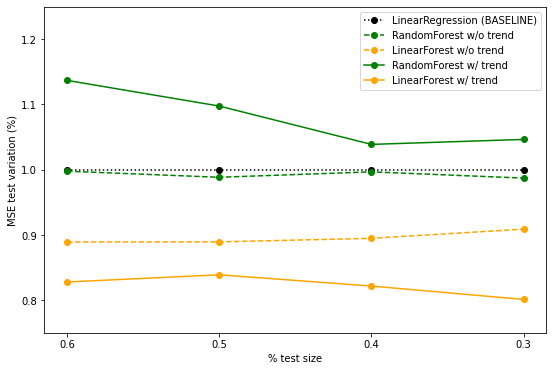

In [29]:
### TEST SET RESULTS ###

plt.figure(figsize=(9,6))
plt.plot([1]*len(test_size), linestyle=':', c='black', marker='o', label='LinearRegression (BASELINE)')

plt.plot(
    [
     e/e_lr for e,e_lr in zip(
         results_without_trend['RandomForest'].values(), 
         results_without_trend['LinearRegression'].values()
        )
    ], c='green', linestyle='--', marker='o', label='RandomForest w/o trend')
plt.plot(
    [
     e/e_lr for e,e_lr in zip(
         results_without_trend['LinearForest'].values(), 
         results_without_trend['LinearRegression'].values()
        )
    ], c='orange', linestyle='--', marker='o', label='LinearForest w/o trend')

plt.plot(
    [
     e/e_lr for e,e_lr in zip(
         results_with_trend['RandomForest'].values(), 
         results_with_trend['LinearRegression'].values()
        )
    ], c='green', marker='o', label='RandomForest w/ trend')
plt.plot(
    [
     e/e_lr for e,e_lr in zip(
         results_with_trend['LinearForest'].values(), 
         results_with_trend['LinearRegression'].values()
        )
    ], c='orange', marker='o', label='LinearForest w/ trend')

plt.xticks(range(len(test_size)), test_size)
plt.xlabel('% test size'); plt.ylabel('MSE test variation (%)'); plt.legend()
plt.ylim([0.75,1.25])
plt.show()

## Model Trees for Time Series

In [30]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

from sklearn.linear_model import *
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV

from lineartree import LinearTreeRegressor

In [31]:
### READ DATA ###

df = pd.read_csv("SimulatedSales.csv.zip")
df.fillna(-1, inplace=True)
df.sort_values(['Store','index'], inplace=True)
df.set_index('index', inplace=True)
df.index.name = None

n_stores = df.Store.nunique()

print(df.shape)
df.head()

(362463, 9)


,Sales,Store,DayOfWeek,Month,WeekOfYear,Promo,Promo2,LocalHoliday,SchoolHoliday
0,4266,85,3,1,1,0,0,0,1
1,3478,85,4,1,1,0,0,0,0
2,4469,85,5,1,1,0,0,0,0
3,1603,85,6,1,1,0,0,0,0
4,6991,85,1,1,2,1,0,0,0


In [32]:
### GET DATA FOR SINGLE STORE ###

id_shop = 1141

X_train, X_test, y_train, y_test = train_test_split(
    df[df['Store'] == id_shop].drop('Sales', axis=1), 
    df[df['Store'] == id_shop]['Sales'], 
    test_size=0.3, shuffle=False)

X_train.shape, X_test.shape

((548, 8), (236, 8))

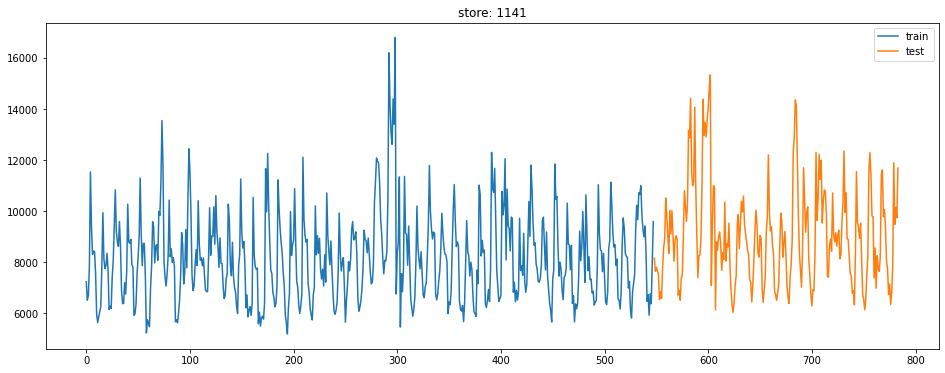

In [33]:
### PLOT STORE DATA ###

y_train.plot(label='train', figsize=(16,6))
y_test.plot(label='test')
plt.title("store: {}".format(id_shop)); plt.legend()

In [34]:
### TUNING LINEAR TREE FOR SINGLE STORE ###

model = GridSearchCV(estimator=LinearTreeRegressor(Ridge(), criterion='rmse'),
                     param_grid={'max_depth': [1, 2, 3], 'min_samples_split': [0.4, 0.3, 0.2]}, 
                     n_jobs=-1, cv=2, scoring='neg_mean_squared_error', refit=True)
model.fit(X_train, y_train)

model.best_params_

{'max_depth': 3, 'min_samples_split': 0.4}

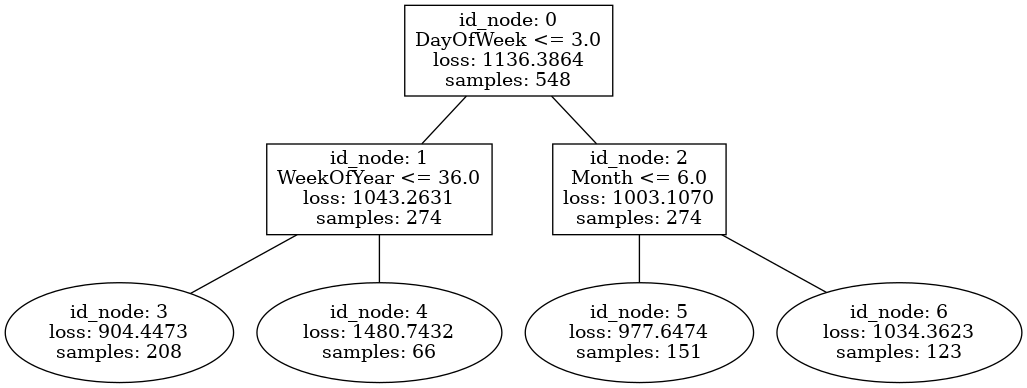

In [35]:
### PLOT MODEL DECISION PATH ###

model.best_estimator_.plot_model(feature_names=X_train.columns)

In [36]:
### COMPUTE TEST ERROR FOR LINEAR TREE ###

pred_lt = pd.Series(model.predict(X_test), index = y_test.index)
mean_squared_error(y_test, pred_lt, squared=False)

1514.4232124930331

In [37]:
### TUNING LINEAR REGRESSION FOR SINGLE STORE ###

model = GridSearchCV(estimator=Ridge(), param_grid={'alpha': [1, 3, 5, 10, 20]}, 
                     scoring='neg_mean_squared_error', cv=2, refit=True)
model.fit(X_train, y_train)

model.best_params_

{'alpha': 5}

In [38]:
### COMPUTE TEST ERROR FOR LINEAR REGRESSION ###

pred_lr = pd.Series(model.predict(X_test), index = y_test.index)
mean_squared_error(y_test, pred_lr, squared=False)

1788.0313792931413

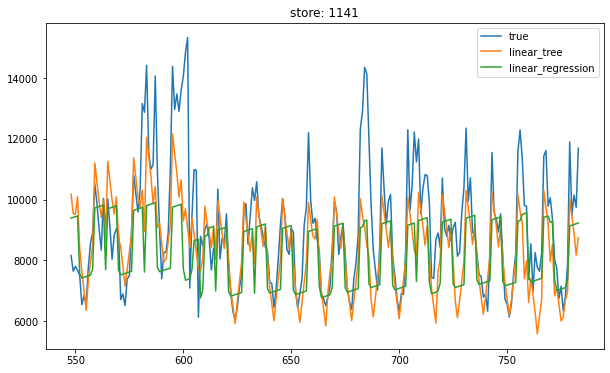

In [39]:
### PLOT AND COMPARE PREDICTIONS ON TEST SET ###

y_test.plot(label='true', figsize=(10,6))
pred_lt.plot(label='linear_tree')
pred_lr.plot(label='linear_regression')
plt.title("store: {}".format(id_shop)); plt.legend()

In [40]:
### FIT LINEAR TREE AND LINEAR REGRESSION FOR ALL THE STORE SEPARATELY ###

scores_lr = {}
scores_lt = {}
                 
for _,g_df in tqdm(df.groupby(['Store']), total=n_stores):

    _X_train, _X_test, _y_train, _y_test = train_test_split(
        g_df.drop('Sales', axis=1), g_df['Sales'], test_size=0.3, shuffle=False)
    
    model = GridSearchCV(estimator=Ridge(), param_grid={'alpha': [1, 3, 5]}, 
                         scoring='neg_mean_squared_error', cv=2, refit=True)
    model.fit(_X_train, _y_train)
    
    _pred = pd.Series(model.predict(_X_test), index = _y_test.index)
    scores_lr[_] = mean_squared_error(_y_test, _pred, squared=False)    

    model = GridSearchCV(estimator=LinearTreeRegressor(Ridge(), criterion='rmse'),
                         param_grid={'max_depth': [1, 2, 3], 'min_samples_split': [0.4, 0.3, 0.2]}, 
                         n_jobs=-1, cv=2, scoring='neg_mean_squared_error', refit=True)
    model.fit(_X_train, _y_train)
    
    _pred = pd.Series(model.predict(_X_test), index = _y_test.index)
    scores_lt[_] = mean_squared_error(_y_test, _pred, squared=False)

100%|██████████| 400/400 [31:16<00:00,  4.69s/it]


In [41]:
### COMPARE ERRORS OF ALL THE STORES ###

compare = {}

for (store,score_lr),(store,score_lt) in zip(scores_lr.items(), scores_lt.items()):
    
    if score_lr > score_lt:
        compare[store] = 'linear tree'
    elif score_lr < score_lt:
        compare[store] = 'linear regression'
    else:
        compare[store] = 'equal'

In [42]:
### GET COMPARISON RATIO ###

pd.Series(compare).value_counts() / len(compare)

linear tree          0.9475
linear regression    0.0525
dtype: float64

(array([0, 1]), [Text(0, 0, 'linear tree'), Text(1, 0, 'linear regression')])

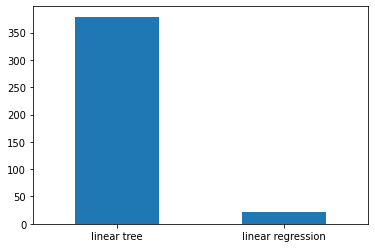

In [43]:
### PLOT PERFORMANCE ###

pd.Series(compare).value_counts().plot.bar()
plt.xticks(rotation=0)